### NOW EXPERIMENTING:
Pinet:
* add some random noice
* custom data generate to update test temperal mask every n epoch
* change unsupervise loss weight on the fly
* used full model (without dropout) for validation and prediction


### Done:
* sample data(train + test) from db, split train data into train val data
* apply test data mask if its none (no temperal mask)
* basic augmentation twice for pinet
* custom pi net loss function
* move prediction into here as it used custom function

### work: 
* image data augmentation, flip, crop,
* resnet with high dropout, (as resnet so easy overfitting, and not enough data)
* 2d spatial dropout
* dice loss, faster converge, but doesn't help improve score....

### not work:
* deeper, shellower
* Clahe
* pure dice loss, it will give binary solution, rather than probability
* dropout=0.6, overfitting, Val=0.8, LB=0.77

### idea:
* augmentation: rotation, affine transform, Elastic deformations
* reduce dropout, as always under fitting
* smaller batch size
* CRF
* inception block


In [1]:
import numpy as np
import pandas as pd
import time, sys, json, os, io, cv2, base64
from io import BytesIO
from subprocess import check_output
from pprint import pprint as pp
import pymongo
from pymongo import MongoClient
import hashlib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from random import randint
from skimage import exposure
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage import transform
from skimage import util
from tqdm import tqdm_notebook
import skimage as sk
import gc
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import keras
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Concatenate, SpatialDropout2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.layers.merge import add
from keras import regularizers
from keras.regularizers import l2
from keras.losses import binary_crossentropy
from keras.activations import softmax
from keras.backend import tensorflow_backend
from keras.backend import common
from keras.callbacks import LambdaCallback
import tensorflow as tf

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
path_train = '../data/train/'
path_test = '../data/test/'
train_ids = next(os.walk(path_train))[2]
test_ids = next(os.walk(path_test))[2]
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = pd.read_csv("../data/train.csv", index_col="id")

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

def insert_data(data, db, collection, check_id='id', host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    
    duplicate_result = db[collection].find(
       {check_id: data[check_id]})
    
    print('duplicate count' + str(duplicate_result.count()))
    if duplicate_result.count() == 0:
        db[collection].insert_one(data)

def set_data(db, collection, search, set_query, host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    db[collection].update(
        search,
        { '$set': set_query }
    )
        
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

def sample_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, num_sample=1000):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].aggregate([{ "$sample": { "size": num_sample }}])

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

# Put all dataset into DF frist, hold in memory

In [4]:
img_size_ori = 101
img_size_target = 128

def read_resize_img(x, scale,mask=False):
    img_byte = io.BytesIO(base64.b64decode(x))
    img_np = np.array(imread(img_byte, as_gray=True))/scale
    img_np = resize(img_np,(img_size_target,img_size_target), mode='constant', preserve_range=True)
    if mask:
        img_np[img_np>0] = 1
    return img_np

train_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$ne":None}}]})
test_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]})
# test_df = sample_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]})

# train_df = train_df.loc[:20]

train_df['img'] = train_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
train_df['img_mask'] = train_df['img_mask_base64'].apply(lambda x: read_resize_img(x, 65535.0, mask=True))
train_df['img_temperal_mask'] = train_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img'] = test_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
test_df['img_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img_temperal_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))

train_df = train_df.drop('img_base64', axis=1)
train_df = train_df.drop('img_mask_base64', axis=1)
train_df = train_df.drop('ASM', axis=1)
train_df = train_df.drop('contrast', axis=1)
train_df = train_df.drop('correlation', axis=1)
train_df = train_df.drop('dissimilarity', axis=1)
train_df = train_df.drop('energy', axis=1)
train_df = train_df.drop('entropy', axis=1)
train_df = train_df.drop('homogeneity', axis=1)
train_df = train_df.drop('coverage', axis=1)
train_df = train_df.drop('coverage_class', axis=1)
test_df = test_df.drop('img_base64', axis=1)

train_df, val_df = train_test_split(train_df, test_size=0.1)

In [5]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3600, 7)
(400, 7)
(18000, 6)


# Data Preprcessing function: sample, augment, to np_array

In [6]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.0005
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.01
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      scale = 0.05
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss * scale
      return noisy
   elif noise_typ == 'None':
      return image

def _img_augmentation(_df):
    def random_crop_resize(x, crop, flip, degree, noise_type='None'):
        # return x if all pixel is -1
        if np.mean(x) == -1:
            return x
        
        x = np.fliplr(x) if flip else x
        x = np.squeeze(noisy(noise_type, np.expand_dims(x, axis=3)))
        x = sk.transform.rotate(x, degree)
        x = x[crop[0]:-crop[1],crop[2]:-crop[3]]
        x = resize(x,(img_size_target,img_size_target), mode='constant', preserve_range=True)
        return x

    def img_augment(df):
        augment_df = pd.DataFrame()
        for index, row in df.iterrows():
            # np.random.seed(0)
            crop = np.random.randint(low=1, high=20, size=4)
            flip = np.random.choice([True, False])
            degree = np.random.uniform(-10, 10)
            noise_type = np.random.choice(['gauss', 'poisson', 's&p', 'speckle', 'None'])
            
            aug_img = random_crop_resize(row['img'], crop, flip, degree, 'speckle')
            aug_img_mask = random_crop_resize(row['img_mask'], crop, flip, degree)
            aug_img_temperal_mask = random_crop_resize(row['img_temperal_mask'], crop, flip, degree)

            
            augment_df = augment_df.append(
                {
                    'depth': row['depth'],
                    'img_id': row['img_id']+'_augment',
                    'aug_img': aug_img,
                    'aug_img_mask': aug_img_mask,
                    'aug_img_temperal_mask': aug_img_temperal_mask,
                }, ignore_index=True
            )
        return augment_df
    
    _augment_df = img_augment(_df)
    
    return _augment_df

def _convert_to_np_array(_augment_df):
    X_np = np.expand_dims(np.stack((np.asarray(_augment_df['aug_img'].values.tolist()))),axis=3)
    y_np = np.expand_dims(np.asarray(_augment_df['aug_img_mask'].values.tolist()),axis=3)
    y_temp_np = np.expand_dims(np.asarray(_augment_df['aug_img_temperal_mask'].values.tolist()),axis=3)
    y_np = np.concatenate((y_np,y_temp_np),axis=3)
    
    return X_np, y_np

def calculate_test_temperal_mask():
    global model_train, test_df, graph_train
    with graph_train.as_default():
        X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
        predict_test = model_train.predict(X_test,batch_size=64, verbose=1)
        predict_test = np.squeeze(predict_test)
    
    for index, row in tqdm_notebook(test_df.iterrows(),total=len(test_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_test[index]
        if(np.mean(img_temperal_mask) < 0):
            test_df.at[index,'img_temperal_mask'] = predict
        else:
            test_df.at[index,'img_temperal_mask'] = (img_temperal_mask + predict)/2
    return test_df

# plot some augmented image

In [7]:
sample_train_df = train_df.sample(50)
train_augment_df = _img_augmentation(sample_train_df)

# %%time
# sample_train_df, sample_val_df, sample_test_df = sample_df(train_df, val_df, test_df)
# train_augment_df, val_augment_df, test_augment_df = img_augmentation(sample_train_df, sample_val_df, sample_test_df)
# X_train, y_train, X_valid, y_valid = convert_to_np_array(train_augment_df, val_augment_df, test_augment_df)

# test_augment_df.head(1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [8]:
# train_augment_df.head(10)

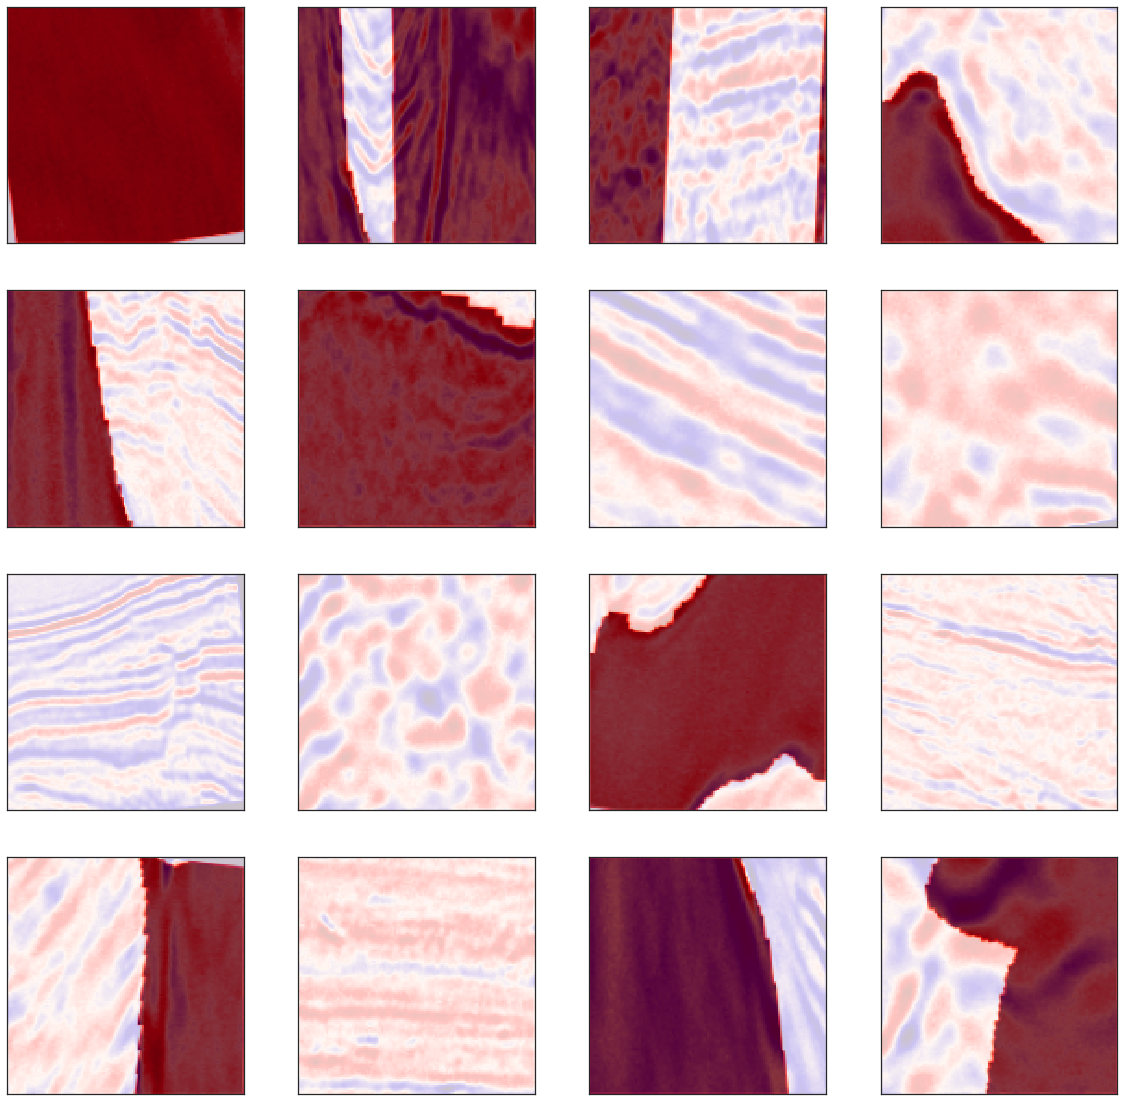

In [9]:
base_idx = 0
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(train_augment_df.index[base_idx:base_idx+int(max_images)]):
    img = train_augment_df.loc[idx].aug_img
    mask = train_augment_df.loc[idx].aug_img_mask
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
#     ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


# Custom loss function

In [10]:
from debug import _debug_func

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def keras_binary_crossentropy(target, output, from_logits=False):
        # Note: tf.nn.sigmoid_cross_entropy_with_logits
        # expects logits, Keras expects probabilities.
        if not from_logits:
            # transform back to logits
            _epsilon = tensorflow_backend._to_tensor(common.epsilon(), output.dtype.base_dtype)
            output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
            output = tf.log(output / (1 - output))
        
        # this will return a tensor
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target,
                                                       logits=output)

# MSE between current and temporal outputs
def temperal_mse_loss(y_true, y_pred):
    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
#         y_temperal = _debug_func(y_temperal,"y_temperal")

    # count temperal size which has value (not -1)
    temperal_size=tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_temperal, [1,2,3]), -1), tf.float32))

    # generate filter using y_temperal
    temperal_filter = tf.cast(tf.not_equal(y_temperal, -1), tf.float32)

    # filter out MSE if temperal = -1
    quad_diff = K.sum(temperal_filter*((y_pred - y_temperal) ** 2))

    quad_diff = quad_diff / (temperal_size*128*128+1e-15)

    return quad_diff

def masked_crossentropy(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])

    # count mask size
    mask_size=tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32))

    # generate mask filter as test doesn't have mask (-1)
    mask_filter = tf.cast(tf.not_equal(y_mask, -1), tf.float32)

    bce_loss = keras_binary_crossentropy(y_mask, y_pred)

    dice_loss_ = dice_loss(mask_filter*y_mask, mask_filter*y_pred)

    bce_dice_loss = dice_loss_ + (K.sum(mask_filter*bce_loss) / (mask_size*128*128+1e-15))

    return bce_dice_loss

def mask_mean_iou(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
    mask_filter = tf.cast(tf.not_equal(y_mask, -1), tf.float32)
    mask_mean_iou = mean_iou(mask_filter*y_mask, mask_filter*y_pred)
    return mask_mean_iou

def temperal_mean_iou(y_true, y_pred):
    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
    temperal_filter = tf.cast(tf.not_equal(y_temperal, -1), tf.float32)
    temperal_mean_iou = mean_iou(temperal_filter*(tf.cast(tf.greater(y_temperal,0.5), tf.float32)), temperal_filter*y_pred)
    return temperal_mean_iou

def temporal_loss(y_true, y_pred):
    sup_loss = masked_crossentropy(y_true, y_pred)
    unsup_loss = temperal_mse_loss(y_true, y_pred)
    w = 0.025
    
    return sup_loss + w * unsup_loss

# DataGenerator

In [11]:
class DataGenerator(keras.utils.Sequence):
    #class static variable
    global model_train
    _train_df = None
    _val_df = None
    _test_df = None
    _X_train = None
    _y_train = None
    _X_valid = None
    _y_valid = None
    
    'Generates data for Keras'
    def __init__(self, train_df, val_df, test_df, batch_size=32, shuffle=True, training=True, temperal_epoch=1):
        self.training = training
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.epoch = 0
        self.train_size = train_df.shape[0]
        self.val_size = val_df.shape[0]
        self.test_size = test_df.shape[0]
        self.train_batch_size = int(self.train_size / (self.train_size + self.test_size)*self.batch_size)
        self.val_batch_size = self.batch_size
        self.test_batch_size = self.batch_size - self.train_batch_size
        self.temperal_epoch = temperal_epoch
        
        print(f'train_size = {self.train_size}, \
              val_size = {self.val_size}, \
              test_size = {self.test_size}, \
              train_batch_size = {self.train_batch_size}, \
              val_batch_size = {self.val_batch_size}, \
              test_batch_size = {self.test_batch_size}, \
              ')
        
        'Initial static variable'
        if self.training:
            DataGenerator._train_df = train_df
            DataGenerator._val_df = val_df
            DataGenerator._test_df = test_df

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.training:
            print('train lenght')
            print(int(np.floor((self.train_size + self.test_size) / self.batch_size)))
            return int(np.floor((self.train_size + self.test_size) / self.batch_size))
        else:
            print('val lenght')
            print(int(np.floor(self.val_size / self.batch_size)))
            return int(np.floor(self.val_size / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        'index: indicate which batch in a epoch, (first, second or third batch)'
        # Generate indexes of the batch
        if self.training:
            if ((index+1)*self.train_batch_size > self.train_size) or ((index+1)*self.test_batch_size > self.test_size):
                index = 0    
            
            # slice batch of df
            batch_train_df = DataGenerator._train_df.iloc[index*self.train_batch_size:(index+1)*self.train_batch_size]
            batch_test_df = DataGenerator._test_df.iloc[index*self.test_batch_size:(index+1)*self.test_batch_size]
            
            # image augmentation
            train_augment_df = _img_augmentation(batch_train_df)
            test_augment_df = _img_augmentation(batch_test_df)
            
            # convert to np and concat train and test
            X_train_np, y_train_np = _convert_to_np_array(train_augment_df)
            X_test_np, y_test_np = _convert_to_np_array(test_augment_df)
            X_train_np = np.concatenate((X_train_np,X_test_np),axis=0)
            y_train_np = np.concatenate((y_train_np,y_test_np),axis=0)
            
            return X_train_np, y_train_np
        else:
            batch_val_df = DataGenerator._val_df.iloc[index*self.val_batch_size:(index+1)*self.val_batch_size]
            val_augment_df = _img_augmentation(batch_val_df)
            X_val_np, y_val_np = _convert_to_np_array(val_augment_df)
            return X_val_np, y_val_np

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        print(f', epoch={self.epoch}')
        self.epoch += 1
        if self.epoch % self.temperal_epoch == 0 and self.training:
            new_test_df = calculate_test_temperal_mask()
            DataGenerator._test_df = new_test_df

# Build Unet + Resnet

In [12]:
# tensorflow session setting
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.Session(config=tf_config))

def conv_block(m, dim, acti, bn, res, do=0, training=None):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = SpatialDropout2D(do/2.0)(n, training=training) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    n = Concatenate()([m, n]) if res else n
    n = SpatialDropout2D(do)(n, training=training) if do else n
    return n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res,training=None):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res, training=training)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res, training=training)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res, training=training)
    else:
        m = conv_block(m, dim, acti, bn, res, do, training=training)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=5, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=True, training=None):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual, training=training)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

# model.compile(loss='binary_crossentropy', optimizer="adam", metrics=[mean_iou,"accuracy"])
# model_train.compile(loss=bce_dice_loss, optimizer="adam", metrics=[mean_iou,"accuracy"])

# used for training unsuperivsed, that keep dropout
global model_train, graph_train
model_train = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.8, training=True)
model_train.compile(loss=temporal_loss, optimizer="adam", metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_train.summary()
graph_train = tf.get_default_graph()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [13]:
epochs = 100
batch_size = 64
callbacks = [
    EarlyStopping(patience=10, verbose=1, monitor="val_mask_mean_iou", mode="max"),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-u-res-pi-net.h5', verbose=1, save_best_only=True, monitor="val_mask_mean_iou", mode="max"),
    ModelCheckpoint('weight-u-res-pi-net.h5', verbose=1, save_best_only=True, monitor="val_mask_mean_iou", mode="max", save_weights_only=True),
]

training_generator = DataGenerator(train_df, val_df, test_df, training=True)
validation_generator = DataGenerator(train_df, val_df, test_df, training=False)

history = model_train.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs, callbacks=callbacks,
                    use_multiprocessing=True,
                    workers=4)

train_size = 3600,               val_size = 400,               test_size = 18000,               train_batch_size = 5,               val_batch_size = 32,               test_batch_size = 27,               
train_size = 3600,               val_size = 400,               test_size = 18000,               train_batch_size = 5,               val_batch_size = 32,               test_batch_size = 27,               
val lenght
12
train lenght
675
train lenghtEpoch 1/100
675



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.9332 - masked_crossentropy: 0.9332 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6516 - temperal_mean_iou: 0.9985, epoch=0
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


 1344/18000 [=>............................] - ETA: 1:11

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


 1408/18000 [=>............................] - ETA: 1:14
Epoch 00001: val_mask_mean_iou improved from -inf to 0.68570, saving model to model-u-res-pi-net.h5
 4096/18000 [=====>........................] - ETA: 46s
Epoch 00001: val_mask_mean_iou improved from -inf to 0.68570, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 39s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.7321 - masked_crossentropy: 0.7308 - temperal_mse_loss: 0.0546 - mask_mean_iou: 0.7061 - temperal_mean_iou: 0.7796, epoch=1
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=1
675/675 [==============================] - 176s 261ms/step - loss: 0.7324 - masked_crossentropy: 0.7311 - temperal_mse_loss: 0.0546 - mask_mean_iou: 0.7061 - temperal_mean_iou: 0.7796 - val_loss: 0.7035 - val_masked_crossentropy: 0.7035 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7214 - val_temperal_mean_iou: 0.7724


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00002: val_mask_mean_iou improved from 0.68570 to 0.72143, saving model to model-u-res-pi-net.h5

Epoch 00002: val_mask_mean_iou improved from 0.68570 to 0.72143, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.6747 - masked_crossentropy: 0.6738 - temperal_mse_loss: 0.0349 - mask_mean_iou: 0.7312 - temperal_mean_iou: 0.7825, epoch=2
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=2


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 186s 275ms/step - loss: 0.6744 - masked_crossentropy: 0.6735 - temperal_mse_loss: 0.0349 - mask_mean_iou: 0.7312 - temperal_mean_iou: 0.7825 - val_loss: 0.6557 - val_masked_crossentropy: 0.6557 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7390 - val_temperal_mean_iou: 0.7893

Epoch 00003: val_mask_mean_iou improved from 0.72143 to 0.73899, saving model to model-u-res-pi-net.h5
 1344/18000 [=>............................] - ETA: 36s
Epoch 00003: val_mask_mean_iou improved from 0.72143 to 0.73899, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.6588 - masked_crossentropy: 0.6580 - temperal_mse_loss: 0.0315 - mask_mean_iou: 0.7437 - temperal_mean_iou: 0.7913, epoch=3
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=3
675/675 [==============================] - 184s 272ms/step - loss: 0.6592 - masked_crossentropy: 0.6584 - temperal_mse_loss: 0.0315 - mask_mean_iou: 0.7437 - temperal_mean_iou: 0.7913 - val_loss: 0.5940 - val_masked_crossentropy: 0.5940 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7489 - val_temperal_mean_iou: 0.7953

Epoch 00004: val_mask_mean_iou improved from 0.73899 to 0.74886, saving model to model-u-res-pi-net.h5

Epoch 00004: val_mask_mean_iou improved from 0.73899 to 0.74886, saving model to weight-u-res-pi-net.h5
Epoch 5/100
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.6349 - masked_crossentropy: 0.6342 - temperal_mse_loss: 0.0255 - mask_mean_iou: 0.7531 - temperal_mean_iou: 0.7990, epoch=4
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=4
675/675 [==============================] - 189s 279ms/step - loss: 0.6342 - masked_crossentropy: 0.6336 - temperal_mse_loss: 0.0255 - mask_mean_iou: 0.7531 - temperal_mean_iou: 0.7991 - val_loss: 0.5796 - val_masked_crossentropy: 0.5796 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7567 - val_temperal_mean_iou: 0.8033

Epoch 00005: val_mask_mean_iou improved from 0.74886 to 0.75667, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.5964 - masked_crossentropy: 0.5957 - temperal_mse_loss: 0.0273 - mask_mean_iou: 0.7605 - temperal_mean_iou: 0.8051, epoch=5
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=5
675/675 [==============================] - 186s 276ms/step - loss: 0.5961 - masked_crossentropy: 0.5955 - temperal_mse_loss: 0.0273 - mask_mean_iou: 0.7605 - temperal_mean_iou: 0.8051 - val_loss: 0.5113 - val_masked_crossentropy: 0.5113 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7644 - val_temperal_mean_iou: 0.8066

Epoch 00006: val_mask_mean_iou improved from 0.75667 to 0.76438, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.5698 - masked_crossentropy: 0.5691 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.7677 - temperal_mean_iou: 0.8099, epoch=6
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=6
675/675 [==============================] - 185s 274ms/step - loss: 0.5694 - masked_crossentropy: 0.5687 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.7677 - temperal_mean_iou: 0.8099 - val_loss: 0.9760 - val_masked_crossentropy: 0.9760 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7703 - val_temperal_mean_iou: 0.8126

Epoch 00007: val_mask_mean_iou improved from 0.76438 to 0.77034, saving model to model-u-res-pi-net.h5
   64/18000 [..............................] - ETA: 41s
Epoch 00007: val_mask_mean_iou improved from 0.76438 to 0.77034, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.5592 - masked_crossentropy: 0.5579 - temperal_mse_loss: 0.0507 - mask_mean_iou: 0.7719 - temperal_mean_iou: 0.8091, epoch=7
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=7
675/675 [==============================] - 187s 276ms/step - loss: 0.5585 - masked_crossentropy: 0.5573 - temperal_mse_loss: 0.0506 - mask_mean_iou: 0.7719 - temperal_mean_iou: 0.8091 - val_loss: 0.6303 - val_masked_crossentropy: 0.6303 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7747 - val_temperal_mean_iou: 0.8060

Epoch 00008: val_mask_mean_iou improved from 0.77034 to 0.77468, saving model to model-u-res-pi-net.h5
  576/18000 [..............................] - ETA: 38s
Epoch 00008: val_mask_mean_iou improved from 0.77034 to 0.77468, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.5409 - masked_crossentropy: 0.5400 - temperal_mse_loss: 0.0332 - mask_mean_iou: 0.7772 - temperal_mean_iou: 0.8082, epoch=8
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=8


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 185s 275ms/step - loss: 0.5417 - masked_crossentropy: 0.5409 - temperal_mse_loss: 0.0332 - mask_mean_iou: 0.7772 - temperal_mean_iou: 0.8082 - val_loss: 0.4868 - val_masked_crossentropy: 0.4868 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7794 - val_temperal_mean_iou: 0.8097

Epoch 00009: val_mask_mean_iou improved from 0.77468 to 0.77939, saving model to model-u-res-pi-net.h5
 1088/18000 [>.............................] - ETA: 37s
Epoch 00009: val_mask_mean_iou improved from 0.77468 to 0.77939, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.5303 - masked_crossentropy: 0.5295 - temperal_mse_loss: 0.0298 - mask_mean_iou: 0.7817 - temperal_mean_iou: 0.8113, epoch=9
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=9


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 185s 274ms/step - loss: 0.5305 - masked_crossentropy: 0.5298 - temperal_mse_loss: 0.0299 - mask_mean_iou: 0.7817 - temperal_mean_iou: 0.8113 - val_loss: 0.4520 - val_masked_crossentropy: 0.4520 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7837 - val_temperal_mean_iou: 0.8131

Epoch 00010: val_mask_mean_iou improved from 0.77939 to 0.78374, saving model to model-u-res-pi-net.h5
 1344/18000 [=>............................] - ETA: 37s
Epoch 00010: val_mask_mean_iou improved from 0.77939 to 0.78374, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.5166 - masked_crossentropy: 0.5159 - temperal_mse_loss: 0.0277 - mask_mean_iou: 0.7859 - temperal_mean_iou: 0.8144, epoch=10
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=10


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 185s 274ms/step - loss: 0.5171 - masked_crossentropy: 0.5164 - temperal_mse_loss: 0.0277 - mask_mean_iou: 0.7859 - temperal_mean_iou: 0.8144 - val_loss: 0.8615 - val_masked_crossentropy: 0.8615 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7874 - val_temperal_mean_iou: 0.8155

Epoch 00011: val_mask_mean_iou improved from 0.78374 to 0.78744, saving model to model-u-res-pi-net.h5
  640/18000 [>.............................] - ETA: 38s
Epoch 00011: val_mask_mean_iou improved from 0.78374 to 0.78744, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4936 - masked_crossentropy: 0.4924 - temperal_mse_loss: 0.0505 - mask_mean_iou: 0.7892 - temperal_mean_iou: 0.8136, epoch=11
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=11


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 186s 275ms/step - loss: 0.4940 - masked_crossentropy: 0.4928 - temperal_mse_loss: 0.0506 - mask_mean_iou: 0.7892 - temperal_mean_iou: 0.8136 - val_loss: 0.4865 - val_masked_crossentropy: 0.4865 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7910 - val_temperal_mean_iou: 0.8118

Epoch 00012: val_mask_mean_iou improved from 0.78744 to 0.79098, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4889 - masked_crossentropy: 0.4880 - temperal_mse_loss: 0.0341 - mask_mean_iou: 0.7925 - temperal_mean_iou: 0.8124, epoch=12
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=12
675/675 [==============================] - 184s 273ms/step - loss: 0.4901 - masked_crossentropy: 0.4892 - temperal_mse_loss: 0.0341 - mask_mean_iou: 0.7925 - temperal_mean_iou: 0.8124 - val_loss: 0.5079 - val_masked_crossentropy: 0.5079 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7942 - val_temperal_mean_iou: 0.8133


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00013: val_mask_mean_iou improved from 0.79098 to 0.79418, saving model to model-u-res-pi-net.h5
 1216/18000 [=>............................] - ETA: 45s
Epoch 00013: val_mask_mean_iou improved from 0.79098 to 0.79418, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4710 - masked_crossentropy: 0.4702 - temperal_mse_loss: 0.0318 - mask_mean_iou: 0.7959 - temperal_mean_iou: 0.8138, epoch=13
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=13


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 184s 273ms/step - loss: 0.4706 - masked_crossentropy: 0.4698 - temperal_mse_loss: 0.0318 - mask_mean_iou: 0.7959 - temperal_mean_iou: 0.8138 - val_loss: 0.4430 - val_masked_crossentropy: 0.4430 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7974 - val_temperal_mean_iou: 0.8143


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00014: val_mask_mean_iou improved from 0.79418 to 0.79740, saving model to model-u-res-pi-net.h5
 1216/18000 [=>............................] - ETA: 36s
Epoch 00014: val_mask_mean_iou improved from 0.79418 to 0.79740, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4951 - masked_crossentropy: 0.4943 - temperal_mse_loss: 0.0287 - mask_mean_iou: 0.7987 - temperal_mean_iou: 0.8157, epoch=14
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=14
675/675 [==============================] - 184s 273ms/step - loss: 0.4945 - masked_crossentropy: 0.4937 - temperal_mse_loss: 0.0287 - mask_mean_iou: 0.7987 - temperal_mean_iou: 0.8157 - val_loss: 0.6941 - val_masked_crossentropy: 0.6941 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7995 - val_temperal_mean_iou: 0.8166

Epoch 00015: val_mask_mean_iou improved from 0.79740 to 0.79951, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4840 - masked_crossentropy: 0.4833 - temperal_mse_loss: 0.0297 - mask_mean_iou: 0.8005 - temperal_mean_iou: 0.8170, epoch=15
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


   64/18000 [..............................] - ETA: 37s, epoch=15


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 185s 275ms/step - loss: 0.4837 - masked_crossentropy: 0.4830 - temperal_mse_loss: 0.0297 - mask_mean_iou: 0.8006 - temperal_mean_iou: 0.8170 - val_loss: 0.8897 - val_masked_crossentropy: 0.8897 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8012 - val_temperal_mean_iou: 0.8176
 - ETA: 2:30
Epoch 00016: val_mask_mean_iou improved from 0.79951 to 0.80119, saving model to model-u-res-pi-net.h5
 1088/18000 [>.............................] - ETA: 48s
Epoch 00016: val_mask_mean_iou improved from 0.79951 to 0.80119, saving model to weight-u-res-pi-net.h5
Epoch 17/100 1984/18000 [==>...........................]
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4757 - masked_crossentropy: 0.4747 - temperal_mse_loss: 0.0403 - mask_mean_iou: 0.8015 - temperal_mean_iou: 0.8176- ETA: 3s - loss: 0.4796 - masked_crossentropy: 0.4786 - temperal_mse_loss: 0.0402 - mask_mean_iou: 0.8015 - temperal_mea, epoch=16
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=16


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 185s 274ms/step - loss: 0.4761 - masked_crossentropy: 0.4751 - temperal_mse_loss: 0.0403 - mask_mean_iou: 0.8015 - temperal_mean_iou: 0.8176 - val_loss: 0.5069 - val_masked_crossentropy: 0.5069 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8026 - val_temperal_mean_iou: 0.8178

Epoch 00017: val_mask_mean_iou improved from 0.80119 to 0.80261, saving model to model-u-res-pi-net.h5
 1152/18000 [>.............................] - ETA: 46s
Epoch 00017: val_mask_mean_iou improved from 0.80119 to 0.80261, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4555 - masked_crossentropy: 0.4547 - temperal_mse_loss: 0.0313 - mask_mean_iou: 0.8038 - temperal_mean_iou: 0.8185, epoch=17
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=17


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 185s 274ms/step - loss: 0.4549 - masked_crossentropy: 0.4541 - temperal_mse_loss: 0.0313 - mask_mean_iou: 0.8038 - temperal_mean_iou: 0.8185 - val_loss: 0.4748 - val_masked_crossentropy: 0.4748 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8049 - val_temperal_mean_iou: 0.8191


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00018: val_mask_mean_iou improved from 0.80261 to 0.80492, saving model to model-u-res-pi-net.h5
  832/18000 [>.............................] - ETA: 37s
Epoch 00018: val_mask_mean_iou improved from 0.80261 to 0.80492, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4432 - masked_crossentropy: 0.4426 - temperal_mse_loss: 0.0238 - mask_mean_iou: 0.8059 - temperal_mean_iou: 0.8204, epoch=18
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


  256/18000 [..............................] - ETA: 1:13

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 187s 277ms/step - loss: 0.4433 - masked_crossentropy: 0.4427 - temperal_mse_loss: 0.0238 - mask_mean_iou: 0.8059 - temperal_mean_iou: 0.8204 - val_loss: 0.4413 - val_masked_crossentropy: 0.4413 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8070 - val_temperal_mean_iou: 0.8217

Epoch 00019: val_mask_mean_iou improved from 0.80492 to 0.80701, saving model to model-u-res-pi-net.h5
 1536/18000 [=>............................] - ETA: 42s
Epoch 00019: val_mask_mean_iou improved from 0.80492 to 0.80701, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4340 - masked_crossentropy: 0.4334 - temperal_mse_loss: 0.0230 - mask_mean_iou: 0.8080 - temperal_mean_iou: 0.8229, epoch=19
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=19
675/675 [==============================] - 185s 275ms/step - loss: 0.4335 - masked_crossentropy: 0.4329 - temperal_mse_loss: 0.0230 - mask_mean_iou: 0.8080 - temperal_mean_iou: 0.8229 - val_loss: 0.4927 - val_masked_crossentropy: 0.4927 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8092 - val_temperal_mean_iou: 0.8241

Epoch 00020: val_mask_mean_iou improved from 0.80701 to 0.80919, saving model to model-u-res-pi-net.h5
  384/18000 [..............................] - ETA: 45s
Epoch 00020: val_mask_mean_iou improved from 0.80701 to 0.80919, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4244 - masked_crossentropy: 0.4238 - temperal_mse_loss: 0.0248 - mask_mean_iou: 0.8103 - temperal_mean_iou: 0.8253, epoch=20
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=20
   64/18000 [..............................] - ETA: 1:16

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 187s 277ms/step - loss: 0.4240 - masked_crossentropy: 0.4234 - temperal_mse_loss: 0.0248 - mask_mean_iou: 0.8103 - temperal_mean_iou: 0.8253 - val_loss: 0.5709 - val_masked_crossentropy: 0.5709 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8113 - val_temperal_mean_iou: 0.8264


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00021: val_mask_mean_iou improved from 0.80919 to 0.81126, saving model to model-u-res-pi-net.h5
 1344/18000 [=>............................] - ETA: 43s
Epoch 00021: val_mask_mean_iou improved from 0.80919 to 0.81126, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4374 - masked_crossentropy: 0.4367 - temperal_mse_loss: 0.0277 - mask_mean_iou: 0.8121 - temperal_mean_iou: 0.8271, epoch=21
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=21
675/675 [==============================] - 186s 276ms/step - loss: 0.4378 - masked_crossentropy: 0.4371 - temperal_mse_loss: 0.0277 - mask_mean_iou: 0.8121 - temperal_mean_iou: 0.8271 - val_loss: 0.4135 - val_masked_crossentropy: 0.4135 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8129 - val_temperal_mean_iou: 0.8279

Epoch 00022: val_mask_mean_iou improved from 0.81126 to 0.81286, saving model to model-u-res-pi-net.h5
 1088/18000 [>.............................] - ETA: 43s
Epoch 00022: val_mask_mean_iou improved from 0.81126 to 0.81286, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4287 - masked_crossentropy: 0.4281 - temperal_mse_loss: 0.0242 - mask_mean_iou: 0.8138 - temperal_mean_iou: 0.8289, epoch=22
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=22


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 186s 276ms/step - loss: 0.4290 - masked_crossentropy: 0.4284 - temperal_mse_loss: 0.0242 - mask_mean_iou: 0.8138 - temperal_mean_iou: 0.8289 - val_loss: 0.5569 - val_masked_crossentropy: 0.5569 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8145 - val_temperal_mean_iou: 0.8298

Epoch 00023: val_mask_mean_iou improved from 0.81286 to 0.81446, saving model to model-u-res-pi-net.h5
 1344/18000 [=>............................] - ETA: 45s
Epoch 00023: val_mask_mean_iou improved from 0.81286 to 0.81446, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4238 - masked_crossentropy: 0.4231 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8152 - temperal_mean_iou: 0.8307, epoch=23
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=23
675/675 [==============================] - 185s 274ms/step - loss: 0.4234 - masked_crossentropy: 0.4227 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8153 - temperal_mean_iou: 0.8307 - val_loss: 0.3703 - val_masked_crossentropy: 0.3703 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8160 - val_temperal_mean_iou: 0.8316

Epoch 00024: val_mask_mean_iou improved from 0.81446 to 0.81597, saving model to model-u-res-pi-net.h5
 1152/18000 [>.............................] - ETA: 33s
Epoch 00024: val_mask_mean_iou improved from 0.81446 to 0.81597, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4061 - masked_crossentropy: 0.4054 - temperal_mse_loss: 0.0266 - mask_mean_iou: 0.8168 - temperal_mean_iou: 0.8323, epoch=24
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=24
675/675 [==============================] - 187s 276ms/step - loss: 0.4056 - masked_crossentropy: 0.4049 - temperal_mse_loss: 0.0266 - mask_mean_iou: 0.8168 - temperal_mean_iou: 0.8323 - val_loss: 0.4152 - val_masked_crossentropy: 0.4152 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8177 - val_temperal_mean_iou: 0.8330


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00025: val_mask_mean_iou improved from 0.81597 to 0.81774, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4082 - masked_crossentropy: 0.4076 - temperal_mse_loss: 0.0243 - mask_mean_iou: 0.8185 - temperal_mean_iou: 0.8339, epoch=25
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=25
675/675 [==============================] - 183s 272ms/step - loss: 0.4089 - masked_crossentropy: 0.4083 - temperal_mse_loss: 0.0243 - mask_mean_iou: 0.8185 - temperal_mean_iou: 0.8339 - val_loss: 0.3707 - val_masked_crossentropy: 0.3707 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8193 - val_temperal_mean_iou: 0.8348

Epoch 00026: val_mask_mean_iou improved from 0.81774 to 0.81932, saving model to model-u-res-pi-net.h5
  704/18000 [>.............................] - ETA: 34s
Epoch 00026: val_mask_mean_iou improved from 0.81774 to 0.81932, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4059 - masked_crossentropy: 0.4053 - temperal_mse_loss: 0.0250 - mask_mean_iou: 0.8202 - temperal_mean_iou: 0.8356, epoch=26
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 184s 272ms/step - loss: 0.4062 - masked_crossentropy: 0.4056 - temperal_mse_loss: 0.0250 - mask_mean_iou: 0.8202 - temperal_mean_iou: 0.8356 - val_loss: 0.4606 - val_masked_crossentropy: 0.4606 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8209 - val_temperal_mean_iou: 0.8362

Epoch 00027: val_mask_mean_iou improved from 0.81932 to 0.82089, saving model to model-u-res-pi-net.h5
 1088/18000 [>.............................] - ETA: 33s
Epoch 00027: val_mask_mean_iou improved from 0.81932 to 0.82089, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.4063 - masked_crossentropy: 0.4057 - temperal_mse_loss: 0.0272 - mask_mean_iou: 0.8215 - temperal_mean_iou: 0.8367, epoch=27
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=26
675/675 [==============================] - 188s 278ms/step - loss: 0.4085 - masked_crossentropy: 0.4079 - temperal_mse_loss: 0.0272 - mask_mean_iou: 0.8215 - temperal_mean_iou: 0.8367 - val_loss: 0.5502 - val_masked_crossentropy: 0.5502 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8221 - val_temperal_mean_iou: 0.8371

Epoch 00028: val_mask_mean_iou improved from 0.82089 to 0.82205, saving model to model-u-res-pi-net.h5

Epoch 00028: val_mask_mean_iou improved from 0.82089 to 0.82205, saving model to weight-u-res-pi-net.h5
Epoch 29/100
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.3858 - masked_crossentropy: 0.3851 - temperal_mse_loss: 0.0284 - mask_mean_iou: 0.8226 - temperal_mean_iou: 0.8377, epoch=28
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


 1536/18000 [=>............................] - ETA: 53s
Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00029: val_mask_mean_iou improved from 0.82205 to 0.82332, saving model to model-u-res-pi-net.h5
 2688/18000 [===>..........................] - ETA: 42s
Epoch 00029: val_mask_mean_iou improved from 0.82205 to 0.82332, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 36s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.3607 - masked_crossentropy: 0.3601 - temperal_mse_loss: 0.0236 - mask_mean_iou: 0.8241 - temperal_mean_iou: 0.8388, epoch=29
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=28
675/675 [==============================] - 192s 285ms/step - loss: 0.3609 - masked_crossentropy: 0.3603 - temperal_mse_loss: 0.0236 - mask_mean_iou: 0.8241 - temperal_mean_iou: 0.8388 - val_loss: 0.4023 - val_masked_crossentropy: 0.4023 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8249 - val_temperal_mean_iou: 0.8395

Epoch 00030: val_mask_mean_iou improved from 0.82332 to 0.82492, saving model to model-u-res-pi-net.h5

Epoch 00030: val_mask_mean_iou improved from 0.82332 to 0.82492, saving model to weight-u-res-pi-net.h5
Epoch 31/100
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.3484 - masked_crossentropy: 0.3478 - temperal_mse_loss: 0.0243 - mask_mean_iou: 0.8257 - temperal_mean_iou: 0.8402, epoch=30
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=29
675/675 [==============================] - 206s 305ms/step - loss: 0.3483 - masked_crossentropy: 0.3477 - temperal_mse_loss: 0.0242 - mask_mean_iou: 0.8257 - temperal_mean_iou: 0.8402 - val_loss: 0.3533 - val_masked_crossentropy: 0.3533 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8266 - val_temperal_mean_iou: 0.8408

Epoch 00031: val_mask_mean_iou improved from 0.82492 to 0.82657, saving model to model-u-res-pi-net.h5

Epoch 00031: val_mask_mean_iou improved from 0.82492 to 0.82657, saving model to weight-u-res-pi-net.h5
Epoch 32/100
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.3317 - masked_crossentropy: 0.3312 - temperal_mse_loss: 0.0238 - mask_mean_iou: 0.8274 - temperal_mean_iou: 0.8415, epoch=31
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=30
675/675 [==============================] - 205s 304ms/step - loss: 0.3318 - masked_crossentropy: 0.3312 - temperal_mse_loss: 0.0238 - mask_mean_iou: 0.8274 - temperal_mean_iou: 0.8415 - val_loss: 0.4240 - val_masked_crossentropy: 0.4240 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8283 - val_temperal_mean_iou: 0.8422

Epoch 00032: val_mask_mean_iou improved from 0.82657 to 0.82831, saving model to model-u-res-pi-net.h5

Epoch 00032: val_mask_mean_iou improved from 0.82657 to 0.82831, saving model to weight-u-res-pi-net.h5
Epoch 33/100
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.3408 - masked_crossentropy: 0.3402 - temperal_mse_loss: 0.0231 - mask_mean_iou: 0.8291 - temperal_mean_iou: 0.8430, epoch=32
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=31
675/675 [==============================] - 201s 298ms/step - loss: 0.3409 - masked_crossentropy: 0.3403 - temperal_mse_loss: 0.0231 - mask_mean_iou: 0.8291 - temperal_mean_iou: 0.8430 - val_loss: 0.3846 - val_masked_crossentropy: 0.3846 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8299 - val_temperal_mean_iou: 0.8436

Epoch 00033: val_mask_mean_iou improved from 0.82831 to 0.82988, saving model to model-u-res-pi-net.h5
   64/18000 [..............................] - ETA: 45s
Epoch 00033: val_mask_mean_iou improved from 0.82831 to 0.82988, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.3156 - masked_crossentropy: 0.3150 - temperal_mse_loss: 0.0237 - mask_mean_iou: 0.8307 - temperal_mean_iou: 0.8441, epoch=33
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=32
675/675 [==============================] - 197s 291ms/step - loss: 0.3155 - masked_crossentropy: 0.3149 - temperal_mse_loss: 0.0238 - mask_mean_iou: 0.8307 - temperal_mean_iou: 0.8441 - val_loss: 0.4119 - val_masked_crossentropy: 0.4119 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8315 - val_temperal_mean_iou: 0.8448

Epoch 00034: val_mask_mean_iou improved from 0.82988 to 0.83147, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.3261 - masked_crossentropy: 0.3255 - temperal_mse_loss: 0.0247 - mask_mean_iou: 0.8322 - temperal_mean_iou: 0.8453, epoch=34
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


  128/18000 [..............................] - ETA: 2:10

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 198s 293ms/step - loss: 0.3257 - masked_crossentropy: 0.3251 - temperal_mse_loss: 0.0246 - mask_mean_iou: 0.8322 - temperal_mean_iou: 0.8453 - val_loss: 0.3972 - val_masked_crossentropy: 0.3972 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8329 - val_temperal_mean_iou: 0.8459


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00035: val_mask_mean_iou improved from 0.83147 to 0.83294, saving model to model-u-res-pi-net.h5
 1536/18000 [=>............................] - ETA: 46s
Epoch 00035: val_mask_mean_iou improved from 0.83147 to 0.83294, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 35s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.3224 - masked_crossentropy: 0.3218 - temperal_mse_loss: 0.0257 - mask_mean_iou: 0.8337 - temperal_mean_iou: 0.8465, epoch=35
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=34
675/675 [==============================] - 193s 286ms/step - loss: 0.3235 - masked_crossentropy: 0.3228 - temperal_mse_loss: 0.0257 - mask_mean_iou: 0.8337 - temperal_mean_iou: 0.8465 - val_loss: 0.4197 - val_masked_crossentropy: 0.4197 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8344 - val_temperal_mean_iou: 0.8470

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00036: val_mask_mean_iou improved from 0.83294 to 0.83439, saving model to model-u-res-pi-net.h5

Epoch 00036: val_mask_mean_iou improved from 0.83294 to 0.83439, saving model to weight-u-res-pi-net.h5
Epoch 37/100
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.3067 - masked_crossentropy: 0.3061 - temperal_mse_loss: 0.0271 - mask_mean_iou: 0.8351 - temperal_mean_iou: 0.8473, epoch=36
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=35
675/675 [==============================] - 199s 295ms/step - loss: 0.3084 - masked_crossentropy: 0.3077 - temperal_mse_loss: 0.0271 - mask_mean_iou: 0.8351 - temperal_mean_iou: 0.8473 - val_loss: 0.3787 - val_masked_crossentropy: 0.3787 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8358 - val_temperal_mean_iou: 0.8476

Epoch 00037: val_mask_mean_iou improved from 0.83439 to 0.83580, saving model to model-u-res-pi-net.h5
  384/18000 [..............................] - ETA: 39s
Epoch 00037: val_mask_mean_iou improved from 0.83439 to 0.83580, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2878 - masked_crossentropy: 0.2871 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.8366 - temperal_mean_iou: 0.8481, epoch=37
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=36
675/675 [==============================] - 197s 292ms/step - loss: 0.2875 - masked_crossentropy: 0.2869 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.8366 - temperal_mean_iou: 0.8481 - val_loss: 0.3535 - val_masked_crossentropy: 0.3535 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8373 - val_temperal_mean_iou: 0.8486

Epoch 00038: val_mask_mean_iou improved from 0.83580 to 0.83735, saving model to model-u-res-pi-net.h5

Epoch 00038: val_mask_mean_iou improved from 0.83580 to 0.83735, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2843 - masked_crossentropy: 0.2836 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8381 - temperal_mean_iou: 0.8491, epoch=38
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=37


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 196s 291ms/step - loss: 0.2840 - masked_crossentropy: 0.2834 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.8381 - temperal_mean_iou: 0.8491 - val_loss: 0.3949 - val_masked_crossentropy: 0.3949 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8388 - val_temperal_mean_iou: 0.8496

Epoch 00039: val_mask_mean_iou improved from 0.83735 to 0.83880, saving model to model-u-res-pi-net.h5
  512/18000 [..............................] - ETA: 43s
Epoch 00039: val_mask_mean_iou improved from 0.83735 to 0.83880, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2840 - masked_crossentropy: 0.2833 - temperal_mse_loss: 0.0263 - mask_mean_iou: 0.8395 - temperal_mean_iou: 0.8500, epoch=39
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=38


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


   64/18000 [..............................] - ETA: 39s
Epoch 00040: val_mask_mean_iou improved from 0.83880 to 0.84021, saving model to model-u-res-pi-net.h5
 1088/18000 [>.............................] - ETA: 39s
Epoch 00040: val_mask_mean_iou improved from 0.83880 to 0.84021, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2716 - masked_crossentropy: 0.2709 - temperal_mse_loss: 0.0285 - mask_mean_iou: 0.8409 - temperal_mean_iou: 0.8508, epoch=40
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=39


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 182s 269ms/step - loss: 0.2715 - masked_crossentropy: 0.2708 - temperal_mse_loss: 0.0286 - mask_mean_iou: 0.8409 - temperal_mean_iou: 0.8508 - val_loss: 0.3523 - val_masked_crossentropy: 0.3523 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8416 - val_temperal_mean_iou: 0.8511

Epoch 00041: val_mask_mean_iou improved from 0.84021 to 0.84162, saving model to model-u-res-pi-net.h5
  320/18000 [..............................] - ETA: 39s
Epoch 00041: val_mask_mean_iou improved from 0.84021 to 0.84162, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2736 - masked_crossentropy: 0.2730 - temperal_mse_loss: 0.0269 - mask_mean_iou: 0.8423 - temperal_mean_iou: 0.8515, epoch=41
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=40


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 184s 273ms/step - loss: 0.2739 - masked_crossentropy: 0.2732 - temperal_mse_loss: 0.0269 - mask_mean_iou: 0.8423 - temperal_mean_iou: 0.8515 - val_loss: 0.4371 - val_masked_crossentropy: 0.4371 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8430 - val_temperal_mean_iou: 0.8518

Epoch 00042: val_mask_mean_iou improved from 0.84162 to 0.84296, saving model to model-u-res-pi-net.h5

Epoch 00042: val_mask_mean_iou improved from 0.84162 to 0.84296, saving model to weight-u-res-pi-net.h5
Epoch 43/100
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2703 - masked_crossentropy: 0.2697 - temperal_mse_loss: 0.0256 - mask_mean_iou: 0.8436 - temperal_mean_iou: 0.8523, epoch=42
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=41


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 196s 290ms/step - loss: 0.2699 - masked_crossentropy: 0.2693 - temperal_mse_loss: 0.0256 - mask_mean_iou: 0.8436 - temperal_mean_iou: 0.8523 - val_loss: 0.3794 - val_masked_crossentropy: 0.3794 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8442 - val_temperal_mean_iou: 0.8526


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00043: val_mask_mean_iou improved from 0.84296 to 0.84421, saving model to model-u-res-pi-net.h5

Epoch 00043: val_mask_mean_iou improved from 0.84296 to 0.84421, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2655 - masked_crossentropy: 0.2649 - temperal_mse_loss: 0.0263 - mask_mean_iou: 0.8449 - temperal_mean_iou: 0.8530, epoch=43
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=42
675/675 [==============================] - 186s 275ms/step - loss: 0.2655 - masked_crossentropy: 0.2649 - temperal_mse_loss: 0.0262 - mask_mean_iou: 0.8449 - temperal_mean_iou: 0.8530 - val_loss: 0.3736 - val_masked_crossentropy: 0.3736 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8455 - val_temperal_mean_iou: 0.8535

Epoch 00044: val_mask_mean_iou improved from 0.84421 to 0.84551, saving model to model-u-res-pi-net.h5

Epoch 00044: val_mask_mean_iou improved from 0.84421 to 0.84551, saving model to weight-u-res-pi-net.h5
Epoch 45/100
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2605 - masked_crossentropy: 0.2598 - temperal_mse_loss: 0.0253 - mask_mean_iou: 0.8462 - temperal_mean_iou: 0.8539, epoch=44
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=43


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


   64/18000 [..............................] - ETA: 6:03
Epoch 00045: val_mask_mean_iou improved from 0.84551 to 0.84673, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2501 - masked_crossentropy: 0.2494 - temperal_mse_loss: 0.0271 - mask_mean_iou: 0.8474 - temperal_mean_iou: 0.8546, epoch=45
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=44
675/675 [==============================] - 183s 271ms/step - loss: 0.2499 - masked_crossentropy: 0.2492 - temperal_mse_loss: 0.0270 - mask_mean_iou: 0.8474 - temperal_mean_iou: 0.8546 - val_loss: 0.3864 - val_masked_crossentropy: 0.3864 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8480 - val_temperal_mean_iou: 0.8550

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00046: val_mask_mean_iou improved from 0.84673 to 0.84800, saving model to model-u-res-pi-net.h5

Epoch 00046: val_mask_mean_iou improved from 0.84673 to 0.84800, saving model to weight-u-res-pi-net.h5
Epoch 47/100
18000/18000 [==============================] - 32s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2454 - masked_crossentropy: 0.2448 - temperal_mse_loss: 0.0253 - mask_mean_iou: 0.8486 - temperal_mean_iou: 0.8554, epoch=46
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


   64/18000 [..............................] - ETA: 42s, epoch=45


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 186s 276ms/step - loss: 0.2452 - masked_crossentropy: 0.2446 - temperal_mse_loss: 0.0254 - mask_mean_iou: 0.8486 - temperal_mean_iou: 0.8554 - val_loss: 0.3855 - val_masked_crossentropy: 0.3855 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8492 - val_temperal_mean_iou: 0.8558

Epoch 00047: val_mask_mean_iou improved from 0.84800 to 0.84918, saving model to model-u-res-pi-net.h5
 1216/18000 [=>............................] - ETA: 53s
Epoch 00047: val_mask_mean_iou improved from 0.84800 to 0.84918, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2431 - masked_crossentropy: 0.2425 - temperal_mse_loss: 0.0254 - mask_mean_iou: 0.8498 - temperal_mean_iou: 0.8562, epoch=47
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=46


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 183s 271ms/step - loss: 0.2430 - masked_crossentropy: 0.2424 - temperal_mse_loss: 0.0254 - mask_mean_iou: 0.8498 - temperal_mean_iou: 0.8562 - val_loss: 0.3841 - val_masked_crossentropy: 0.3841 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8504 - val_temperal_mean_iou: 0.8565

Epoch 00048: val_mask_mean_iou improved from 0.84918 to 0.85038, saving model to model-u-res-pi-net.h5

Epoch 00048: val_mask_mean_iou improved from 0.84918 to 0.85038, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2421 - masked_crossentropy: 0.2415 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8510 - temperal_mean_iou: 0.8569, epoch=48
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=47


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


  192/18000 [..............................] - ETA: 2:39
Epoch 00049: val_mask_mean_iou improved from 0.85038 to 0.85154, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 35s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2547 - masked_crossentropy: 0.2540 - temperal_mse_loss: 0.0274 - mask_mean_iou: 0.8521 - temperal_mean_iou: 0.8575, epoch=49
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


  128/18000 [..............................] - ETA: 51s, epoch=48


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 189s 280ms/step - loss: 0.2544 - masked_crossentropy: 0.2537 - temperal_mse_loss: 0.0274 - mask_mean_iou: 0.8521 - temperal_mean_iou: 0.8575 - val_loss: 0.3906 - val_masked_crossentropy: 0.3906 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8526 - val_temperal_mean_iou: 0.8578
 - ETA: 2:19
Epoch 00050: val_mask_mean_iou improved from 0.85154 to 0.85256, saving model to model-u-res-pi-net.h5
 1280/18000 [=>............................] - ETA: 52s
Epoch 00050: val_mask_mean_iou improved from 0.85154 to 0.85256, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 35s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2399 - masked_crossentropy: 0.2392 - temperal_mse_loss: 0.0289 - mask_mean_iou: 0.8531 - temperal_mean_iou: 0.8580, epoch=50
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=49
675/675 [==============================] - 191s 284ms/step - loss: 0.2397 - masked_crossentropy: 0.2390 - temperal_mse_loss: 0.0289 - mask_mean_iou: 0.8531 - temperal_mean_iou: 0.8580 - val_loss: 0.4190 - val_masked_crossentropy: 0.4190 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8536 - val_temperal_mean_iou: 0.8582

Epoch 00051: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00051: val_mask_mean_iou improved from 0.85256 to 0.85363, saving model to model-u-res-pi-net.h5
  768/18000 [>.............................] - ETA: 35s
Epoch 00051: val_mask_mean_iou improved from 0.85256 to 0.85363, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2296 - masked_crossentropy: 0.2290 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8542 - temperal_mean_iou: 0.8585, epoch=51
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=50
675/675 [==============================] - 196s 290ms/step - loss: 0.2294 - masked_crossentropy: 0.2288 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8542 - temperal_mean_iou: 0.8585 - val_loss: 0.3957 - val_masked_crossentropy: 0.3957 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8547 - val_temperal_mean_iou: 0.8588

Epoch 00052: val_mask_mean_iou improved from 0.85363 to 0.85472, saving model to model-u-res-pi-net.h5
  192/18000 [..............................] - ETA: 44s
Epoch 00052: val_mask_mean_iou improved from 0.85363 to 0.85472, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2274 - masked_crossentropy: 0.2268 - temperal_mse_loss: 0.0267 - mask_mean_iou: 0.8553 - temperal_mean_iou: 0.8591, epoch=52
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=51
675/675 [==============================] - 197s 291ms/step - loss: 0.2273 - masked_crossentropy: 0.2267 - temperal_mse_loss: 0.0267 - mask_mean_iou: 0.8553 - temperal_mean_iou: 0.8591 - val_loss: 0.3958 - val_masked_crossentropy: 0.3958 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8558 - val_temperal_mean_iou: 0.8594

Epoch 00053: val_mask_mean_iou improved from 0.85472 to 0.85579, saving model to model-u-res-pi-net.h5
  512/18000 [..............................] - ETA: 36s
Epoch 00053: val_mask_mean_iou improved from 0.85472 to 0.85579, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2294 - masked_crossentropy: 0.2286 - temperal_mse_loss: 0.0290 - mask_mean_iou: 0.8563 - temperal_mean_iou: 0.8596, epoch=53
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=52
675/675 [==============================] - 196s 291ms/step - loss: 0.2294 - masked_crossentropy: 0.2287 - temperal_mse_loss: 0.0290 - mask_mean_iou: 0.8563 - temperal_mean_iou: 0.8596 - val_loss: 0.3955 - val_masked_crossentropy: 0.3955 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8568 - val_temperal_mean_iou: 0.8598


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00054: val_mask_mean_iou improved from 0.85579 to 0.85683, saving model to model-u-res-pi-net.h5
  704/18000 [>.............................] - ETA: 41s
Epoch 00054: val_mask_mean_iou improved from 0.85579 to 0.85683, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2210 - masked_crossentropy: 0.2203 - temperal_mse_loss: 0.0283 - mask_mean_iou: 0.8574 - temperal_mean_iou: 0.8601, epoch=54
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=53


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 195s 290ms/step - loss: 0.2208 - masked_crossentropy: 0.2201 - temperal_mse_loss: 0.0283 - mask_mean_iou: 0.8574 - temperal_mean_iou: 0.8601 - val_loss: 0.3747 - val_masked_crossentropy: 0.3747 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8579 - val_temperal_mean_iou: 0.8603

Epoch 00055: val_mask_mean_iou improved from 0.85683 to 0.85786, saving model to model-u-res-pi-net.h5
  576/18000 [..............................] - ETA: 50s
Epoch 00055: val_mask_mean_iou improved from 0.85683 to 0.85786, saving model to weight-u-res-pi-net.h5
16256/18000 [==========================>...] - ETA: 3s


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2287 - masked_crossentropy: 0.2280 - temperal_mse_loss: 0.0296 - mask_mean_iou: 0.8584 - temperal_mean_iou: 0.8605, epoch=55
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=54
675/675 [==============================] - 195s 289ms/step - loss: 0.2286 - masked_crossentropy: 0.2278 - temperal_mse_loss: 0.0296 - mask_mean_iou: 0.8584 - temperal_mean_iou: 0.8605 - val_loss: 0.3780 - val_masked_crossentropy: 0.3780 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8588 - val_temperal_mean_iou: 0.8607

Epoch 00056: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00056: val_mask_mean_iou improved from 0.85786 to 0.85885, saving model to model-u-res-pi-net.h5
  576/18000 [..............................] - ETA: 38s
Epoch 00056: val_mask_mean_iou improved from 0.85786 to 0.85885, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2258 - masked_crossentropy: 0.2251 - temperal_mse_loss: 0.0270 - mask_mean_iou: 0.8593 - temperal_mean_iou: 0.8609, epoch=56
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=55
675/675 [==============================] - 196s 290ms/step - loss: 0.2255 - masked_crossentropy: 0.2248 - temperal_mse_loss: 0.0270 - mask_mean_iou: 0.8593 - temperal_mean_iou: 0.8609 - val_loss: 0.3828 - val_masked_crossentropy: 0.3828 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8598 - val_temperal_mean_iou: 0.8612


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00057: val_mask_mean_iou improved from 0.85885 to 0.85977, saving model to model-u-res-pi-net.h5

Epoch 00057: val_mask_mean_iou improved from 0.85885 to 0.85977, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2210 - masked_crossentropy: 0.2203 - temperal_mse_loss: 0.0269 - mask_mean_iou: 0.8602 - temperal_mean_iou: 0.8614, epoch=57
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=56


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 199s 295ms/step - loss: 0.2208 - masked_crossentropy: 0.2201 - temperal_mse_loss: 0.0269 - mask_mean_iou: 0.8602 - temperal_mean_iou: 0.8614 - val_loss: 0.3985 - val_masked_crossentropy: 0.3985 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8607 - val_temperal_mean_iou: 0.8617


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00058: val_mask_mean_iou improved from 0.85977 to 0.86068, saving model to model-u-res-pi-net.h5
  960/18000 [>.............................] - ETA: 35s
Epoch 00058: val_mask_mean_iou improved from 0.85977 to 0.86068, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2166 - masked_crossentropy: 0.2159 - temperal_mse_loss: 0.0278 - mask_mean_iou: 0.8612 - temperal_mean_iou: 0.8619, epoch=58
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=57
675/675 [==============================] - 197s 292ms/step - loss: 0.2163 - masked_crossentropy: 0.2156 - temperal_mse_loss: 0.0278 - mask_mean_iou: 0.8612 - temperal_mean_iou: 0.8619 - val_loss: 0.3880 - val_masked_crossentropy: 0.3880 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8616 - val_temperal_mean_iou: 0.8621

Epoch 00059: val_mask_mean_iou improved from 0.86068 to 0.86161, saving model to model-u-res-pi-net.h5
  128/18000 [..............................] - ETA: 38s
Epoch 00059: val_mask_mean_iou improved from 0.86068 to 0.86161, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2186 - masked_crossentropy: 0.2179 - temperal_mse_loss: 0.0288 - mask_mean_iou: 0.8621 - temperal_mean_iou: 0.8623, epoch=59
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=58
675/675 [==============================] - 197s 292ms/step - loss: 0.2184 - masked_crossentropy: 0.2177 - temperal_mse_loss: 0.0289 - mask_mean_iou: 0.8621 - temperal_mean_iou: 0.8623 - val_loss: 0.4089 - val_masked_crossentropy: 0.4089 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8625 - val_temperal_mean_iou: 0.8625

Epoch 00060: val_mask_mean_iou improved from 0.86161 to 0.86249, saving model to model-u-res-pi-net.h5

Epoch 00060: val_mask_mean_iou improved from 0.86161 to 0.86249, saving model to weight-u-res-pi-net.h5
Epoch 61/100
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2170 - masked_crossentropy: 0.2163 - temperal_mse_loss: 0.0270 - mask_mean_iou: 0.8629 - temperal_mean_iou: 0.8628, epoch=60
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=59


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 199s 294ms/step - loss: 0.2167 - masked_crossentropy: 0.2160 - temperal_mse_loss: 0.0270 - mask_mean_iou: 0.8629 - temperal_mean_iou: 0.8628 - val_loss: 0.3923 - val_masked_crossentropy: 0.3923 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8633 - val_temperal_mean_iou: 0.8630


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00061: val_mask_mean_iou improved from 0.86249 to 0.86334, saving model to model-u-res-pi-net.h5

Epoch 00061: val_mask_mean_iou improved from 0.86249 to 0.86334, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2218 - masked_crossentropy: 0.2211 - temperal_mse_loss: 0.0286 - mask_mean_iou: 0.8637 - temperal_mean_iou: 0.8632, epoch=61
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=60
675/675 [==============================] - 197s 292ms/step - loss: 0.2231 - masked_crossentropy: 0.2224 - temperal_mse_loss: 0.0286 - mask_mean_iou: 0.8637 - temperal_mean_iou: 0.8632 - val_loss: 0.3863 - val_masked_crossentropy: 0.3863 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8641 - val_temperal_mean_iou: 0.8633

Epoch 00062: val_mask_mean_iou improved from 0.86334 to 0.86412, saving model to model-u-res-pi-net.h5
  384/18000 [..............................] - ETA: 48s
Epoch 00062: val_mask_mean_iou improved from 0.86334 to 0.86412, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2199 - masked_crossentropy: 0.2192 - temperal_mse_loss: 0.0281 - mask_mean_iou: 0.8645 - temperal_mean_iou: 0.8635, epoch=62
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=61


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 197s 292ms/step - loss: 0.2199 - masked_crossentropy: 0.2191 - temperal_mse_loss: 0.0281 - mask_mean_iou: 0.8645 - temperal_mean_iou: 0.8635 - val_loss: 0.4202 - val_masked_crossentropy: 0.4202 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8649 - val_temperal_mean_iou: 0.8637

Epoch 00063: val_mask_mean_iou improved from 0.86412 to 0.86490, saving model to model-u-res-pi-net.h5
  256/18000 [..............................] - ETA: 41s
Epoch 00063: val_mask_mean_iou improved from 0.86412 to 0.86490, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2109 - masked_crossentropy: 0.2102 - temperal_mse_loss: 0.0279 - mask_mean_iou: 0.8653 - temperal_mean_iou: 0.8639, epoch=63
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=62
675/675 [==============================] - 196s 290ms/step - loss: 0.2107 - masked_crossentropy: 0.2100 - temperal_mse_loss: 0.0279 - mask_mean_iou: 0.8653 - temperal_mean_iou: 0.8639 - val_loss: 0.3951 - val_masked_crossentropy: 0.3951 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8657 - val_temperal_mean_iou: 0.8640

Epoch 00064: val_mask_mean_iou improved from 0.86490 to 0.86572, saving model to model-u-res-pi-net.h5
  832/18000 [>.............................] - ETA: 38s
Epoch 00064: val_mask_mean_iou improved from 0.86490 to 0.86572, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2204 - masked_crossentropy: 0.2197 - temperal_mse_loss: 0.0284 - mask_mean_iou: 0.8661 - temperal_mean_iou: 0.8642, epoch=64
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=63
675/675 [==============================] - 196s 290ms/step - loss: 0.2204 - masked_crossentropy: 0.2197 - temperal_mse_loss: 0.0285 - mask_mean_iou: 0.8661 - temperal_mean_iou: 0.8642 - val_loss: 0.3865 - val_masked_crossentropy: 0.3865 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8665 - val_temperal_mean_iou: 0.8644

Epoch 00065: val_mask_mean_iou improved from 0.86572 to 0.86646, saving model to model-u-res-pi-net.h5
  960/18000 [>.............................] - ETA: 56s
Epoch 00065: val_mask_mean_iou improved from 0.86572 to 0.86646, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 35s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2090 - masked_crossentropy: 0.2083 - temperal_mse_loss: 0.0281 - mask_mean_iou: 0.8669 - temperal_mean_iou: 0.8646, epoch=65
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=64
675/675 [==============================] - 196s 290ms/step - loss: 0.2087 - masked_crossentropy: 0.2080 - temperal_mse_loss: 0.0281 - mask_mean_iou: 0.8669 - temperal_mean_iou: 0.8646 - val_loss: 0.3947 - val_masked_crossentropy: 0.3947 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8672 - val_temperal_mean_iou: 0.8647

Epoch 00066: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00066: val_mask_mean_iou improved from 0.86646 to 0.86720, saving model to model-u-res-pi-net.h5
  384/18000 [..............................] - ETA: 48s
Epoch 00066: val_mask_mean_iou improved from 0.86646 to 0.86720, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2118 - masked_crossentropy: 0.2111 - temperal_mse_loss: 0.0286 - mask_mean_iou: 0.8676 - temperal_mean_iou: 0.8649, epoch=66
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=65
675/675 [==============================] - 196s 291ms/step - loss: 0.2116 - masked_crossentropy: 0.2109 - temperal_mse_loss: 0.0286 - mask_mean_iou: 0.8676 - temperal_mean_iou: 0.8649 - val_loss: 0.4159 - val_masked_crossentropy: 0.4159 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8679 - val_temperal_mean_iou: 0.8651

Epoch 00067: val_mask_mean_iou improved from 0.86720 to 0.86793, saving model to model-u-res-pi-net.h5

Epoch 00067: val_mask_mean_iou improved from 0.86720 to 0.86793, saving model to weight-u-res-pi-net.h5
Epoch 68/100
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2166 - masked_crossentropy: 0.2158 - temperal_mse_loss: 0.0295 - mask_mean_iou: 0.8683 - temperal_mean_iou: 0.8652, epoch=67
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=66
675/675 [==============================] - 199s 295ms/step - loss: 0.2163 - masked_crossentropy: 0.2156 - temperal_mse_loss: 0.0296 - mask_mean_iou: 0.8683 - temperal_mean_iou: 0.8652 - val_loss: 0.4062 - val_masked_crossentropy: 0.4062 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8686 - val_temperal_mean_iou: 0.8653

Epoch 00068: val_mask_mean_iou improved from 0.86793 to 0.86864, saving model to model-u-res-pi-net.h5
 1216/18000 [=>............................] - ETA: 34s
Epoch 00068: val_mask_mean_iou improved from 0.86793 to 0.86864, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2174 - masked_crossentropy: 0.2166 - temperal_mse_loss: 0.0291 - mask_mean_iou: 0.8690 - temperal_mean_iou: 0.8655, epoch=68
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=67
   64/18000 [..............................] - ETA: 4:13

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


  128/18000 [..............................] - ETA: 3:05
Epoch 00069: val_mask_mean_iou improved from 0.86864 to 0.86930, saving model to model-u-res-pi-net.h5
 1088/18000 [>.............................] - ETA: 53s
Epoch 00069: val_mask_mean_iou improved from 0.86864 to 0.86930, saving model to weight-u-res-pi-net.h5
Epoch 70/100[==>...........................] - ETA: 43
674/675 [============================>.] - ETA: 0s - loss: 0.2234 - masked_crossentropy: 0.2226 - temperal_mse_loss: 0.0293 - mask_mean_iou: 0.8696 - temperal_mean_iou: 0.8658, epoch=69
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=68


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 188s 278ms/step - loss: 0.2233 - masked_crossentropy: 0.2226 - temperal_mse_loss: 0.0293 - mask_mean_iou: 0.8696 - temperal_mean_iou: 0.8658 - val_loss: 0.4047 - val_masked_crossentropy: 0.4047 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8699 - val_temperal_mean_iou: 0.8659

Epoch 00070: val_mask_mean_iou improved from 0.86930 to 0.86993, saving model to model-u-res-pi-net.h5

Epoch 00070: val_mask_mean_iou improved from 0.86930 to 0.86993, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 35s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2155 - masked_crossentropy: 0.2147 - temperal_mse_loss: 0.0289 - mask_mean_iou: 0.8703 - temperal_mean_iou: 0.8660, epoch=70
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=69
675/675 [==============================] - 186s 276ms/step - loss: 0.2155 - masked_crossentropy: 0.2148 - temperal_mse_loss: 0.0289 - mask_mean_iou: 0.8703 - temperal_mean_iou: 0.8660 - val_loss: 0.3894 - val_masked_crossentropy: 0.3894 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8706 - val_temperal_mean_iou: 0.8661

Epoch 00071: val_mask_mean_iou improved from 0.86993 to 0.87057, saving model to model-u-res-pi-net.h5

Epoch 00071: val_mask_mean_iou improved from 0.86993 to 0.87057, saving model to weight-u-res-pi-net.h5
Epoch 72/100
18000/18000 [==============================] - 32s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2103 - masked_crossentropy: 0.2096 - temperal_mse_loss: 0.0288 - mask_mean_iou: 0.8709 - temperal_mean_iou: 0.8663, epoch=71
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=70


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 187s 277ms/step - loss: 0.2102 - masked_crossentropy: 0.2094 - temperal_mse_loss: 0.0287 - mask_mean_iou: 0.8709 - temperal_mean_iou: 0.8663 - val_loss: 0.3813 - val_masked_crossentropy: 0.3813 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8712 - val_temperal_mean_iou: 0.8664

Epoch 00072: val_mask_mean_iou improved from 0.87057 to 0.87121, saving model to model-u-res-pi-net.h5

Epoch 00072: val_mask_mean_iou improved from 0.87057 to 0.87121, saving model to weight-u-res-pi-net.h5
Epoch 73/100
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2156 - masked_crossentropy: 0.2149 - temperal_mse_loss: 0.0282 - mask_mean_iou: 0.8715 - temperal_mean_iou: 0.8665, epoch=72
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=71
675/675 [==============================] - 187s 277ms/step - loss: 0.2155 - masked_crossentropy: 0.2148 - temperal_mse_loss: 0.0283 - mask_mean_iou: 0.8715 - temperal_mean_iou: 0.8665 - val_loss: 0.3816 - val_masked_crossentropy: 0.3816 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8718 - val_temperal_mean_iou: 0.8667


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00073: val_mask_mean_iou improved from 0.87121 to 0.87180, saving model to model-u-res-pi-net.h5

Epoch 00073: val_mask_mean_iou improved from 0.87121 to 0.87180, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2093 - masked_crossentropy: 0.2086 - temperal_mse_loss: 0.0288 - mask_mean_iou: 0.8721 - temperal_mean_iou: 0.8668, epoch=73
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=72
675/675 [==============================] - 185s 273ms/step - loss: 0.2092 - masked_crossentropy: 0.2085 - temperal_mse_loss: 0.0288 - mask_mean_iou: 0.8721 - temperal_mean_iou: 0.8668 - val_loss: 0.3845 - val_masked_crossentropy: 0.3845 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8724 - val_temperal_mean_iou: 0.8669

Epoch 00074: val_mask_mean_iou improved from 0.87180 to 0.87241, saving model to model-u-res-pi-net.h5

Epoch 00074: val_mask_mean_iou improved from 0.87180 to 0.87241, saving model to weight-u-res-pi-net.h5
Epoch 75/100
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2052 - masked_crossentropy: 0.2044 - temperal_mse_loss: 0.0285 - mask_mean_iou: 0.8727 - temperal_mean_iou: 0.8671, epoch=74
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=73


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 189s 281ms/step - loss: 0.2050 - masked_crossentropy: 0.2043 - temperal_mse_loss: 0.0285 - mask_mean_iou: 0.8727 - temperal_mean_iou: 0.8671 - val_loss: 0.4133 - val_masked_crossentropy: 0.4133 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8730 - val_temperal_mean_iou: 0.8672

Epoch 00075: val_mask_mean_iou improved from 0.87241 to 0.87300, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2133 - masked_crossentropy: 0.2125 - temperal_mse_loss: 0.0296 - mask_mean_iou: 0.8733 - temperal_mean_iou: 0.8673, epoch=75
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=74


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 183s 271ms/step - loss: 0.2130 - masked_crossentropy: 0.2123 - temperal_mse_loss: 0.0297 - mask_mean_iou: 0.8733 - temperal_mean_iou: 0.8673 - val_loss: 0.4054 - val_masked_crossentropy: 0.4054 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8736 - val_temperal_mean_iou: 0.8674

Epoch 00076: val_mask_mean_iou improved from 0.87300 to 0.87356, saving model to model-u-res-pi-net.h5

Epoch 00076: val_mask_mean_iou improved from 0.87300 to 0.87356, saving model to weight-u-res-pi-net.h5
Epoch 77/100
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2069 - masked_crossentropy: 0.2061 - temperal_mse_loss: 0.0298 - mask_mean_iou: 0.8738 - temperal_mean_iou: 0.8675, epoch=76
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=75
675/675 [==============================] - 186s 275ms/step - loss: 0.2067 - masked_crossentropy: 0.2060 - temperal_mse_loss: 0.0298 - mask_mean_iou: 0.8738 - temperal_mean_iou: 0.8675 - val_loss: 0.4197 - val_masked_crossentropy: 0.4197 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8741 - val_temperal_mean_iou: 0.8676


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00077: val_mask_mean_iou improved from 0.87356 to 0.87412, saving model to model-u-res-pi-net.h5
  640/18000 [>.............................] - ETA: 39s
Epoch 00077: val_mask_mean_iou improved from 0.87356 to 0.87412, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2205 - masked_crossentropy: 0.2197 - temperal_mse_loss: 0.0292 - mask_mean_iou: 0.8744 - temperal_mean_iou: 0.8677, epoch=77
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=76
675/675 [==============================] - 183s 272ms/step - loss: 0.2206 - masked_crossentropy: 0.2199 - temperal_mse_loss: 0.0291 - mask_mean_iou: 0.8744 - temperal_mean_iou: 0.8677 - val_loss: 0.3926 - val_masked_crossentropy: 0.3926 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8746 - val_temperal_mean_iou: 0.8678

Epoch 00078: val_mask_mean_iou improved from 0.87412 to 0.87464, saving model to model-u-res-pi-net.h5
   64/18000 [..............................] - ETA: 35s
Epoch 00078: val_mask_mean_iou improved from 0.87412 to 0.87464, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2191 - masked_crossentropy: 0.2184 - temperal_mse_loss: 0.0291 - mask_mean_iou: 0.8749 - temperal_mean_iou: 0.8679, epoch=78
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=77
675/675 [==============================] - 184s 273ms/step - loss: 0.2188 - masked_crossentropy: 0.2181 - temperal_mse_loss: 0.0291 - mask_mean_iou: 0.8749 - temperal_mean_iou: 0.8679 - val_loss: 0.3987 - val_masked_crossentropy: 0.3987 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8751 - val_temperal_mean_iou: 0.8680


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00079: val_mask_mean_iou improved from 0.87464 to 0.87515, saving model to model-u-res-pi-net.h5

Epoch 00079: val_mask_mean_iou improved from 0.87464 to 0.87515, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2125 - masked_crossentropy: 0.2117 - temperal_mse_loss: 0.0288 - mask_mean_iou: 0.8754 - temperal_mean_iou: 0.8681, epoch=79
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=78


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 185s 274ms/step - loss: 0.2123 - masked_crossentropy: 0.2116 - temperal_mse_loss: 0.0288 - mask_mean_iou: 0.8754 - temperal_mean_iou: 0.8681 - val_loss: 0.3990 - val_masked_crossentropy: 0.3990 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8757 - val_temperal_mean_iou: 0.8682

Epoch 00080: val_mask_mean_iou improved from 0.87515 to 0.87566, saving model to model-u-res-pi-net.h5
  384/18000 [..............................] - ETA: 36s
Epoch 00080: val_mask_mean_iou improved from 0.87515 to 0.87566, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2063 - masked_crossentropy: 0.2056 - temperal_mse_loss: 0.0277 - mask_mean_iou: 0.8759 - temperal_mean_iou: 0.8684, epoch=80
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=79


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 184s 273ms/step - loss: 0.2061 - masked_crossentropy: 0.2054 - temperal_mse_loss: 0.0277 - mask_mean_iou: 0.8759 - temperal_mean_iou: 0.8684 - val_loss: 0.4022 - val_masked_crossentropy: 0.4022 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8762 - val_temperal_mean_iou: 0.8685

Epoch 00081: val_mask_mean_iou improved from 0.87566 to 0.87619, saving model to model-u-res-pi-net.h5
  512/18000 [..............................] - ETA: 40s
Epoch 00081: val_mask_mean_iou improved from 0.87566 to 0.87619, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2141 - masked_crossentropy: 0.2134 - temperal_mse_loss: 0.0290 - mask_mean_iou: 0.8764 - temperal_mean_iou: 0.8686, epoch=81
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=80
675/675 [==============================] - 184s 272ms/step - loss: 0.2146 - masked_crossentropy: 0.2139 - temperal_mse_loss: 0.0290 - mask_mean_iou: 0.8764 - temperal_mean_iou: 0.8686 - val_loss: 0.3961 - val_masked_crossentropy: 0.3961 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8767 - val_temperal_mean_iou: 0.8687

Epoch 00082: val_mask_mean_iou improved from 0.87619 to 0.87667, saving model to model-u-res-pi-net.h5
  320/18000 [..............................] - ETA: 38s
Epoch 00082: val_mask_mean_iou improved from 0.87619 to 0.87667, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2171 - masked_crossentropy: 0.2164 - temperal_mse_loss: 0.0289 - mask_mean_iou: 0.8769 - temperal_mean_iou: 0.8688, epoch=82
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=81
675/675 [==============================] - 184s 273ms/step - loss: 0.2169 - masked_crossentropy: 0.2162 - temperal_mse_loss: 0.0290 - mask_mean_iou: 0.8769 - temperal_mean_iou: 0.8688 - val_loss: 0.3839 - val_masked_crossentropy: 0.3839 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8772 - val_temperal_mean_iou: 0.8689

Epoch 00083: val_mask_mean_iou improved from 0.87667 to 0.87716, saving model to model-u-res-pi-net.h5
  448/18000 [..............................] - ETA: 35s
Epoch 00083: val_mask_mean_iou improved from 0.87667 to 0.87716, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2073 - masked_crossentropy: 0.2066 - temperal_mse_loss: 0.0291 - mask_mean_iou: 0.8774 - temperal_mean_iou: 0.8690, epoch=83
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=82


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 184s 273ms/step - loss: 0.2071 - masked_crossentropy: 0.2063 - temperal_mse_loss: 0.0291 - mask_mean_iou: 0.8774 - temperal_mean_iou: 0.8690 - val_loss: 0.4029 - val_masked_crossentropy: 0.4029 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8776 - val_temperal_mean_iou: 0.8691

Epoch 00084: val_mask_mean_iou improved from 0.87716 to 0.87765, saving model to model-u-res-pi-net.h5
  768/18000 [>.............................] - ETA: 43s
Epoch 00084: val_mask_mean_iou improved from 0.87716 to 0.87765, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2055 - masked_crossentropy: 0.2047 - temperal_mse_loss: 0.0284 - mask_mean_iou: 0.8779 - temperal_mean_iou: 0.8692, epoch=84
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=83
675/675 [==============================] - 184s 272ms/step - loss: 0.2053 - masked_crossentropy: 0.2046 - temperal_mse_loss: 0.0284 - mask_mean_iou: 0.8779 - temperal_mean_iou: 0.8692 - val_loss: 0.4072 - val_masked_crossentropy: 0.4072 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8781 - val_temperal_mean_iou: 0.8693


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00085: val_mask_mean_iou improved from 0.87765 to 0.87813, saving model to model-u-res-pi-net.h5
  256/18000 [..............................] - ETA: 49s
Epoch 00085: val_mask_mean_iou improved from 0.87765 to 0.87813, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2176 - masked_crossentropy: 0.2169 - temperal_mse_loss: 0.0297 - mask_mean_iou: 0.8783 - temperal_mean_iou: 0.8693, epoch=85
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=84


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 185s 274ms/step - loss: 0.2180 - masked_crossentropy: 0.2172 - temperal_mse_loss: 0.0297 - mask_mean_iou: 0.8783 - temperal_mean_iou: 0.8693 - val_loss: 0.3909 - val_masked_crossentropy: 0.3909 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8785 - val_temperal_mean_iou: 0.8694

Epoch 00086: val_mask_mean_iou improved from 0.87813 to 0.87853, saving model to model-u-res-pi-net.h5
  512/18000 [..............................] - ETA: 43s
Epoch 00086: val_mask_mean_iou improved from 0.87813 to 0.87853, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2012 - masked_crossentropy: 0.2005 - temperal_mse_loss: 0.0295 - mask_mean_iou: 0.8788 - temperal_mean_iou: 0.8695, epoch=86
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=85
675/675 [==============================] - 183s 272ms/step - loss: 0.2010 - masked_crossentropy: 0.2003 - temperal_mse_loss: 0.0295 - mask_mean_iou: 0.8788 - temperal_mean_iou: 0.8695 - val_loss: 0.4061 - val_masked_crossentropy: 0.4061 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8790 - val_temperal_mean_iou: 0.8696

Epoch 00087: val_mask_mean_iou improved from 0.87853 to 0.87899, saving model to model-u-res-pi-net.h5
  512/18000 [..............................] - ETA: 35s
Epoch 00087: val_mask_mean_iou improved from 0.87853 to 0.87899, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


636/675 [===========================>..] - ETA: 10s - loss: 0.2092 - masked_crossentropy: 0.2085 - temperal_mse_loss: 0.0289 - mask_mean_iou: 0.8792 - temperal_mean_iou: 0.8697

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 185s 274ms/step - loss: 0.2107 - masked_crossentropy: 0.2100 - temperal_mse_loss: 0.0290 - mask_mean_iou: 0.8792 - temperal_mean_iou: 0.8697 - val_loss: 0.4018 - val_masked_crossentropy: 0.4018 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8794 - val_temperal_mean_iou: 0.8698


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00088: val_mask_mean_iou improved from 0.87899 to 0.87944, saving model to model-u-res-pi-net.h5

Epoch 00088: val_mask_mean_iou improved from 0.87899 to 0.87944, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2061 - masked_crossentropy: 0.2054 - temperal_mse_loss: 0.0291 - mask_mean_iou: 0.8797 - temperal_mean_iou: 0.8699, epoch=88
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=87


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 187s 277ms/step - loss: 0.2061 - masked_crossentropy: 0.2054 - temperal_mse_loss: 0.0291 - mask_mean_iou: 0.8797 - temperal_mean_iou: 0.8699 - val_loss: 0.3856 - val_masked_crossentropy: 0.3856 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8799 - val_temperal_mean_iou: 0.8699

Epoch 00089: val_mask_mean_iou improved from 0.87944 to 0.87988, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2154 - masked_crossentropy: 0.2147 - temperal_mse_loss: 0.0288 - mask_mean_iou: 0.8801 - temperal_mean_iou: 0.8700, epoch=89
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=88
675/675 [==============================] - 185s 274ms/step - loss: 0.2152 - masked_crossentropy: 0.2145 - temperal_mse_loss: 0.0287 - mask_mean_iou: 0.8801 - temperal_mean_iou: 0.8700 - val_loss: 0.4205 - val_masked_crossentropy: 0.4205 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8803 - val_temperal_mean_iou: 0.8701

Epoch 00090: val_mask_mean_iou improved from 0.87988 to 0.88029, saving model to model-u-res-pi-net.h5
  512/18000 [..............................] - ETA: 36s
Epoch 00090: val_mask_mean_iou improved from 0.87988 to 0.88029, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2122 - masked_crossentropy: 0.2115 - temperal_mse_loss: 0.0291 - mask_mean_iou: 0.8805 - temperal_mean_iou: 0.8702, epoch=90
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=89


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 185s 274ms/step - loss: 0.2120 - masked_crossentropy: 0.2113 - temperal_mse_loss: 0.0290 - mask_mean_iou: 0.8805 - temperal_mean_iou: 0.8702 - val_loss: 0.4078 - val_masked_crossentropy: 0.4078 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8807 - val_temperal_mean_iou: 0.8703


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00091: val_mask_mean_iou improved from 0.88029 to 0.88070, saving model to model-u-res-pi-net.h5
  320/18000 [..............................] - ETA: 43s
Epoch 00091: val_mask_mean_iou improved from 0.88029 to 0.88070, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2041 - masked_crossentropy: 0.2034 - temperal_mse_loss: 0.0287 - mask_mean_iou: 0.8809 - temperal_mean_iou: 0.8704, epoch=91
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=90
675/675 [==============================] - 186s 276ms/step - loss: 0.2045 - masked_crossentropy: 0.2038 - temperal_mse_loss: 0.0287 - mask_mean_iou: 0.8809 - temperal_mean_iou: 0.8704 - val_loss: 0.3801 - val_masked_crossentropy: 0.3801 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8811 - val_temperal_mean_iou: 0.8705

Epoch 00092: val_mask_mean_iou improved from 0.88070 to 0.88111, saving model to model-u-res-pi-net.h5

Epoch 00092: val_mask_mean_iou improved from 0.88070 to 0.88111, saving model to weight-u-res-pi-net.h5
Epoch 93/100
18000/18000 [==============================] - 32s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2080 - masked_crossentropy: 0.2073 - temperal_mse_loss: 0.0293 - mask_mean_iou: 0.8813 - temperal_mean_iou: 0.8705, epoch=92
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=91
675/675 [==============================] - 187s 277ms/step - loss: 0.2081 - masked_crossentropy: 0.2073 - temperal_mse_loss: 0.0293 - mask_mean_iou: 0.8813 - temperal_mean_iou: 0.8705 - val_loss: 0.4077 - val_masked_crossentropy: 0.4077 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8815 - val_temperal_mean_iou: 0.8706


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00093: val_mask_mean_iou improved from 0.88111 to 0.88150, saving model to model-u-res-pi-net.h5
 1280/18000 [=>............................] - ETA: 37s
Epoch 00093: val_mask_mean_iou improved from 0.88111 to 0.88150, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2051 - masked_crossentropy: 0.2043 - temperal_mse_loss: 0.0299 - mask_mean_iou: 0.8817 - temperal_mean_iou: 0.8707, epoch=93
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=92


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 184s 272ms/step - loss: 0.2049 - masked_crossentropy: 0.2042 - temperal_mse_loss: 0.0300 - mask_mean_iou: 0.8817 - temperal_mean_iou: 0.8707 - val_loss: 0.4264 - val_masked_crossentropy: 0.4264 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8819 - val_temperal_mean_iou: 0.8707

Epoch 00094: val_mask_mean_iou improved from 0.88150 to 0.88188, saving model to model-u-res-pi-net.h5
  448/18000 [..............................] - ETA: 46s
Epoch 00094: val_mask_mean_iou improved from 0.88150 to 0.88188, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2075 - masked_crossentropy: 0.2068 - temperal_mse_loss: 0.0303 - mask_mean_iou: 0.8821 - temperal_mean_iou: 0.8708, epoch=94
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=93
675/675 [==============================] - 185s 275ms/step - loss: 0.2073 - masked_crossentropy: 0.2065 - temperal_mse_loss: 0.0303 - mask_mean_iou: 0.8821 - temperal_mean_iou: 0.8708 - val_loss: 0.4051 - val_masked_crossentropy: 0.4051 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8823 - val_temperal_mean_iou: 0.8709

Epoch 00095: val_mask_mean_iou improved from 0.88188 to 0.88227, saving model to model-u-res-pi-net.h5
  576/18000 [..............................] - ETA: 37s
Epoch 00095: val_mask_mean_iou improved from 0.88188 to 0.88227, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2091 - masked_crossentropy: 0.2084 - temperal_mse_loss: 0.0294 - mask_mean_iou: 0.8824 - temperal_mean_iou: 0.8709, epoch=95
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=94


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 186s 275ms/step - loss: 0.2090 - masked_crossentropy: 0.2082 - temperal_mse_loss: 0.0294 - mask_mean_iou: 0.8824 - temperal_mean_iou: 0.8709 - val_loss: 0.3968 - val_masked_crossentropy: 0.3968 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8826 - val_temperal_mean_iou: 0.8710

Epoch 00096: val_mask_mean_iou improved from 0.88227 to 0.88261, saving model to model-u-res-pi-net.h5
  704/18000 [>.............................] - ETA: 41s
Epoch 00096: val_mask_mean_iou improved from 0.88227 to 0.88261, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2103 - masked_crossentropy: 0.2095 - temperal_mse_loss: 0.0300 - mask_mean_iou: 0.8828 - temperal_mean_iou: 0.8710, epoch=96
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=95


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 184s 273ms/step - loss: 0.2101 - masked_crossentropy: 0.2093 - temperal_mse_loss: 0.0300 - mask_mean_iou: 0.8828 - temperal_mean_iou: 0.8710 - val_loss: 0.3942 - val_masked_crossentropy: 0.3942 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8830 - val_temperal_mean_iou: 0.8711

Epoch 00097: val_mask_mean_iou improved from 0.88261 to 0.88299, saving model to model-u-res-pi-net.h5
  576/18000 [..............................] - ETA: 38s
Epoch 00097: val_mask_mean_iou improved from 0.88261 to 0.88299, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 33s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2077 - masked_crossentropy: 0.2070 - temperal_mse_loss: 0.0307 - mask_mean_iou: 0.8832 - temperal_mean_iou: 0.8712, epoch=97
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


  384/18000 [..............................] - ETA: 1:04

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 186s 275ms/step - loss: 0.2075 - masked_crossentropy: 0.2068 - temperal_mse_loss: 0.0307 - mask_mean_iou: 0.8832 - temperal_mean_iou: 0.8712 - val_loss: 0.4167 - val_masked_crossentropy: 0.4167 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8833 - val_temperal_mean_iou: 0.8712

Epoch 00098: val_mask_mean_iou improved from 0.88299 to 0.88334, saving model to model-u-res-pi-net.h5
 1344/18000 [=>............................] - ETA: 55s
Epoch 00098: val_mask_mean_iou improved from 0.88299 to 0.88334, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 35s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2128 - masked_crossentropy: 0.2121 - temperal_mse_loss: 0.0297 - mask_mean_iou: 0.8835 - temperal_mean_iou: 0.8712, epoch=98
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


  384/18000 [..............................] - ETA: 1:26
Epoch 00099: val_mask_mean_iou improved from 0.88334 to 0.88368, saving model to model-u-res-pi-net.h5
 1536/18000 [=>............................] - ETA: 44s
Epoch 00099: val_mask_mean_iou improved from 0.88334 to 0.88368, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 34s 2ms/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


674/675 [============================>.] - ETA: 0s - loss: 0.2069 - masked_crossentropy: 0.2062 - temperal_mse_loss: 0.0302 - mask_mean_iou: 0.8838 - temperal_mean_iou: 0.8713, epoch=99
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


  256/18000 [..............................] - ETA: 43s, epoch=98


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


675/675 [==============================] - 184s 273ms/step - loss: 0.2070 - masked_crossentropy: 0.2063 - temperal_mse_loss: 0.0302 - mask_mean_iou: 0.8838 - temperal_mean_iou: 0.8713 - val_loss: 0.4013 - val_masked_crossentropy: 0.4013 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8840 - val_temperal_mean_iou: 0.8714

Epoch 00100: val_mask_mean_iou improved from 0.88368 to 0.88401, saving model to model-u-res-pi-net.h5
 1344/18000 [=>............................] - ETA: 53s
Epoch 00100: val_mask_mean_iou improved from 0.88368 to 0.88401, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 35s 2ms/step


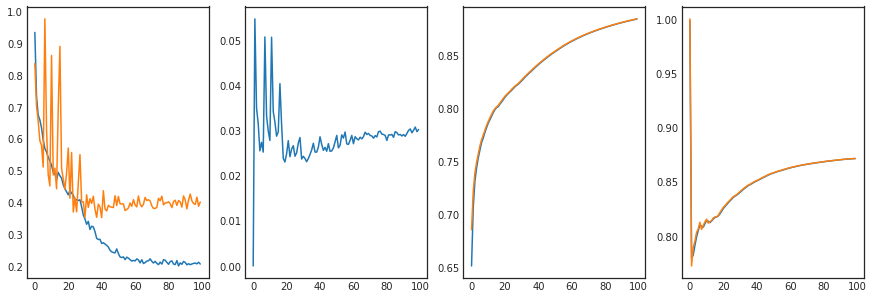

In [14]:
fig, (ax_loss, ax_temp_loss, ax_acc, ax_iou) = plt.subplots(1,4, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_temp_loss.plot(history.epoch, history.history["temperal_mse_loss"], label="Train loss")
# ax_temp_loss.plot(history.epoch, history.history["val_temperal_mse_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mask_mean_iou"], label="Train mask iou")
ax_acc.plot(history.epoch, history.history["val_mask_mean_iou"], label="Validation mask iou")
ax_iou.plot(history.epoch, history.history["temperal_mean_iou"], label="Train temperal iou")
ax_iou.plot(history.epoch, history.history["val_temperal_mean_iou"], label="Validation temperal iou")

# Fine tune threshold

In [15]:
# model = load_model("./model-unet-resnet.h5", custom_objects={'mean_iou':mean_iou})

# # used for predict, no dropout
model_predict = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.0, training=False)
model_predict.compile(loss=temporal_loss, optimizer="adam", metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_predict.set_weights(model_train.get_weights())

X_valid = np.expand_dims(np.stack((np.asarray(val_df['img'].values.tolist()))),axis=3)
y_valid = np.expand_dims(np.asarray(val_df['img_mask'].values.tolist()),axis=3)
preds_valid = model_predict.predict(X_valid, batch_size=32, verbose=1)

400/400 [==============================] - 2s 6ms/step


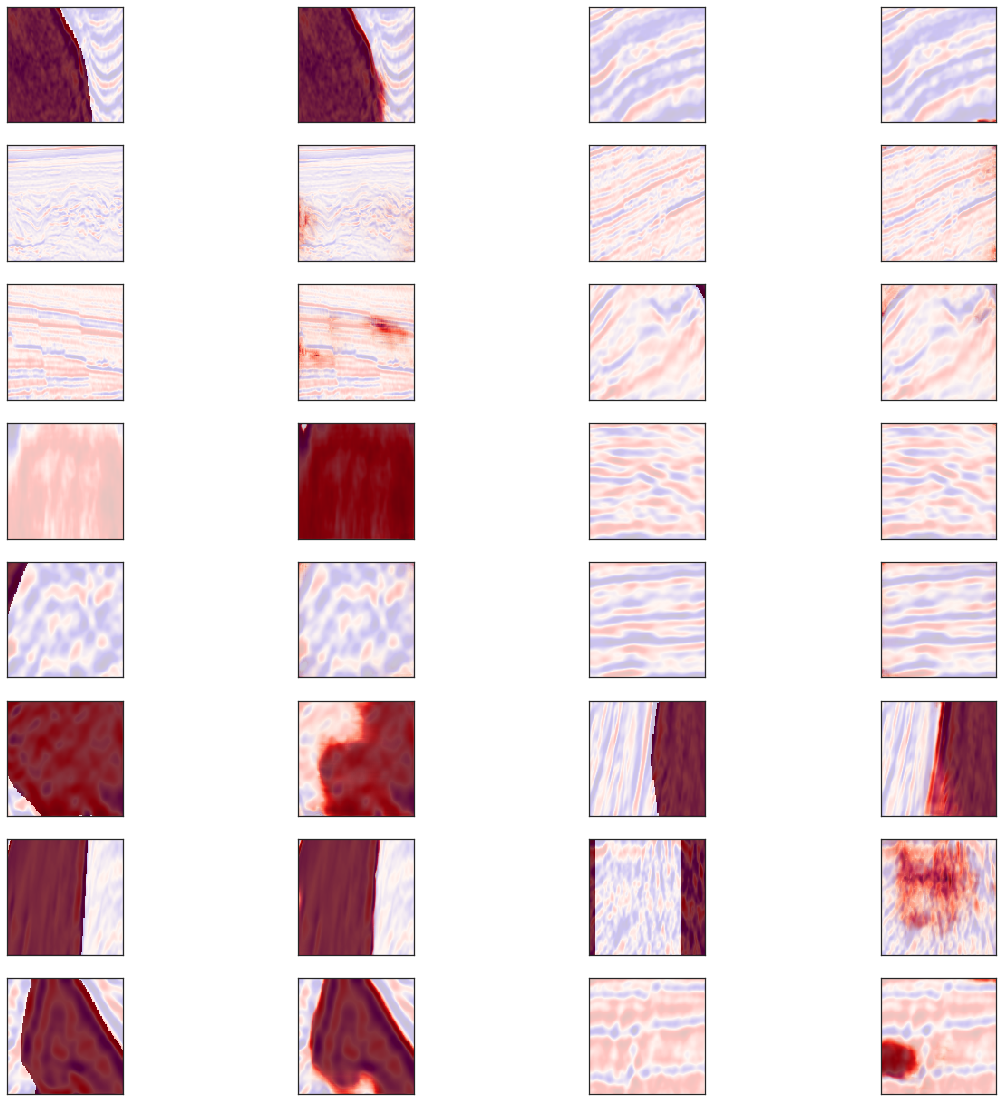

In [16]:
# plot some validate result
base_idx = 10
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(val_df.index[base_idx:base_idx+int(max_images/2)]):
    img = val_df.iloc[i].img
    mask = val_df.iloc[i].img_mask
    pred = preds_valid[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(pred, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]);ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


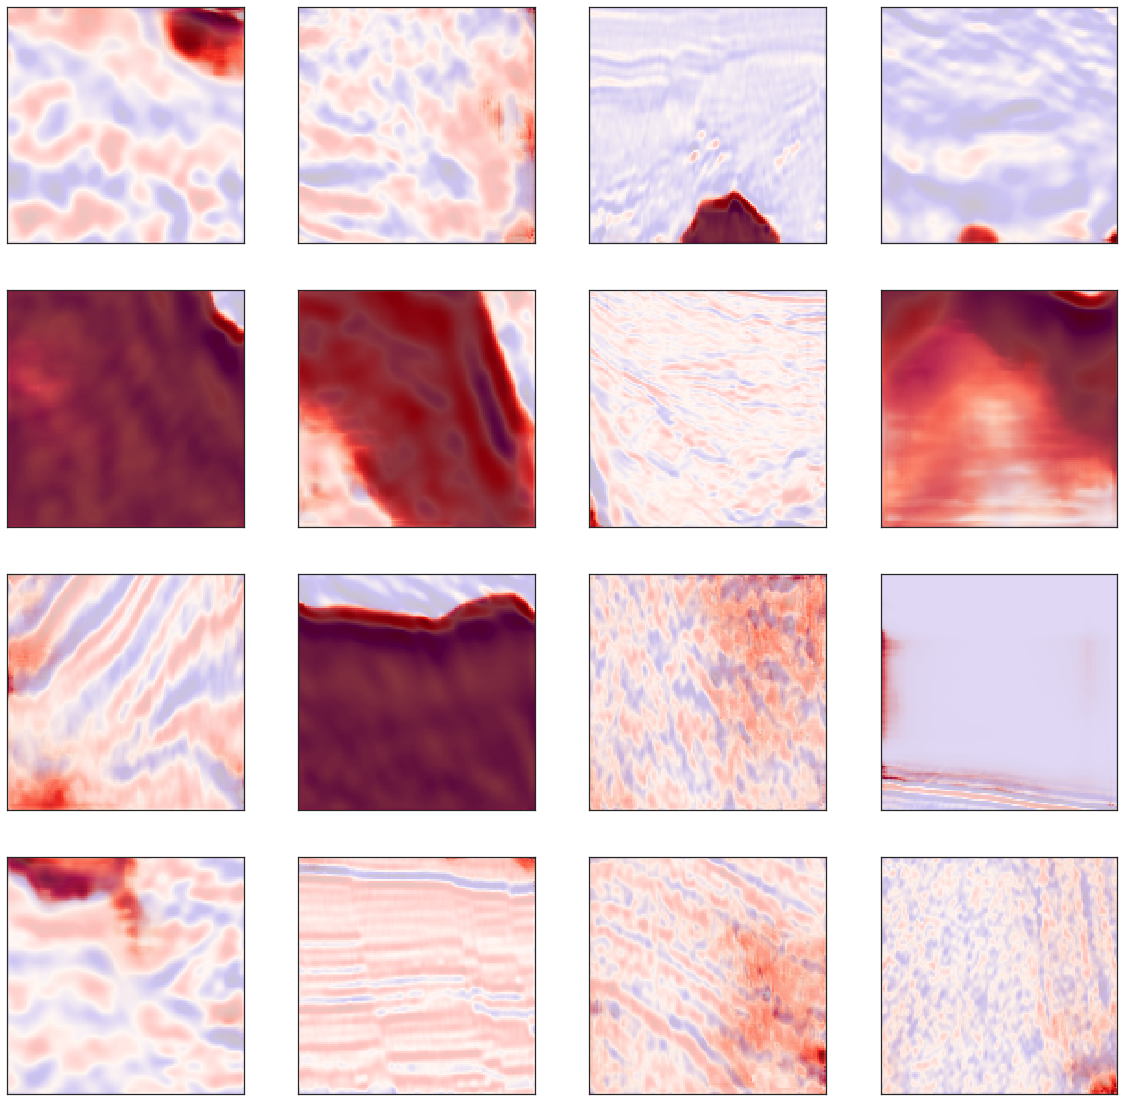

In [17]:
# plot some temperal mask on test results
base_idx = 0
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(test_df.index[base_idx:base_idx+int(max_images)]):
    img = test_df.loc[idx].img
    mask = test_df.loc[idx].img_temperal_mask
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
#     ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [18]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch],print_table=False)
        metric.append(value)
    return np.mean(metric)


from math import sqrt
from joblib import Parallel, delayed
import multiprocessing  
from tqdm import tqdm  

thresholds = np.linspace(0, 1, 20)
# result = Parallel(n_jobs=2)(io_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds))
# ious = np.array([iou_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

threshold_best: 0.8421052631578947, iou_best: 0.7509999999999999


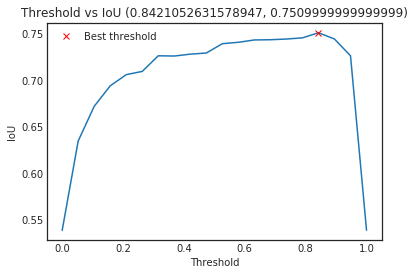

In [19]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(f'threshold_best: {threshold_best}, iou_best: {iou_best}')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Predict test data

In [20]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]
    
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [21]:
X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
preds_test = model_predict.predict(X_test, batch_size=32, verbose=1)
final_preds_test = preds_test > threshold_best

18000/18000 [==============================] - 34s 2ms/step


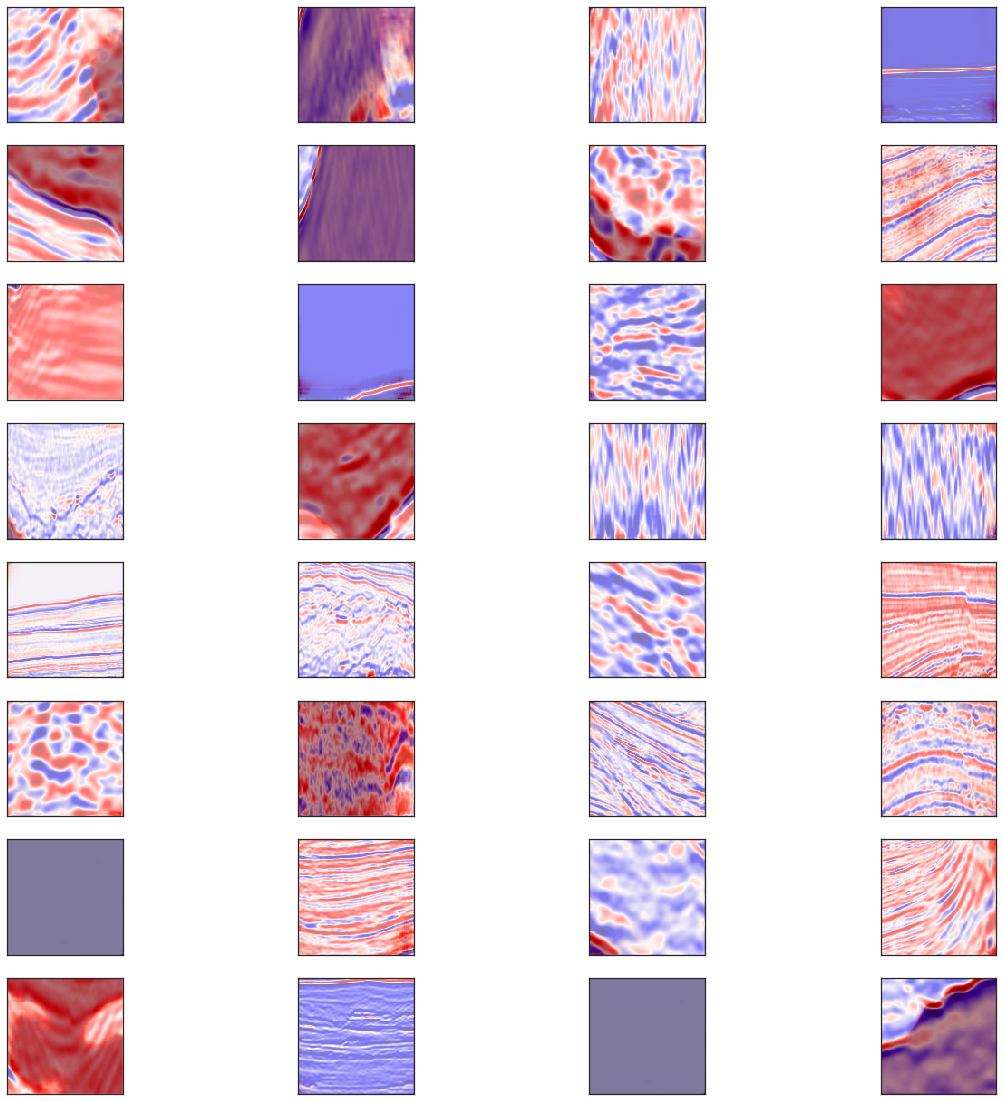

In [22]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

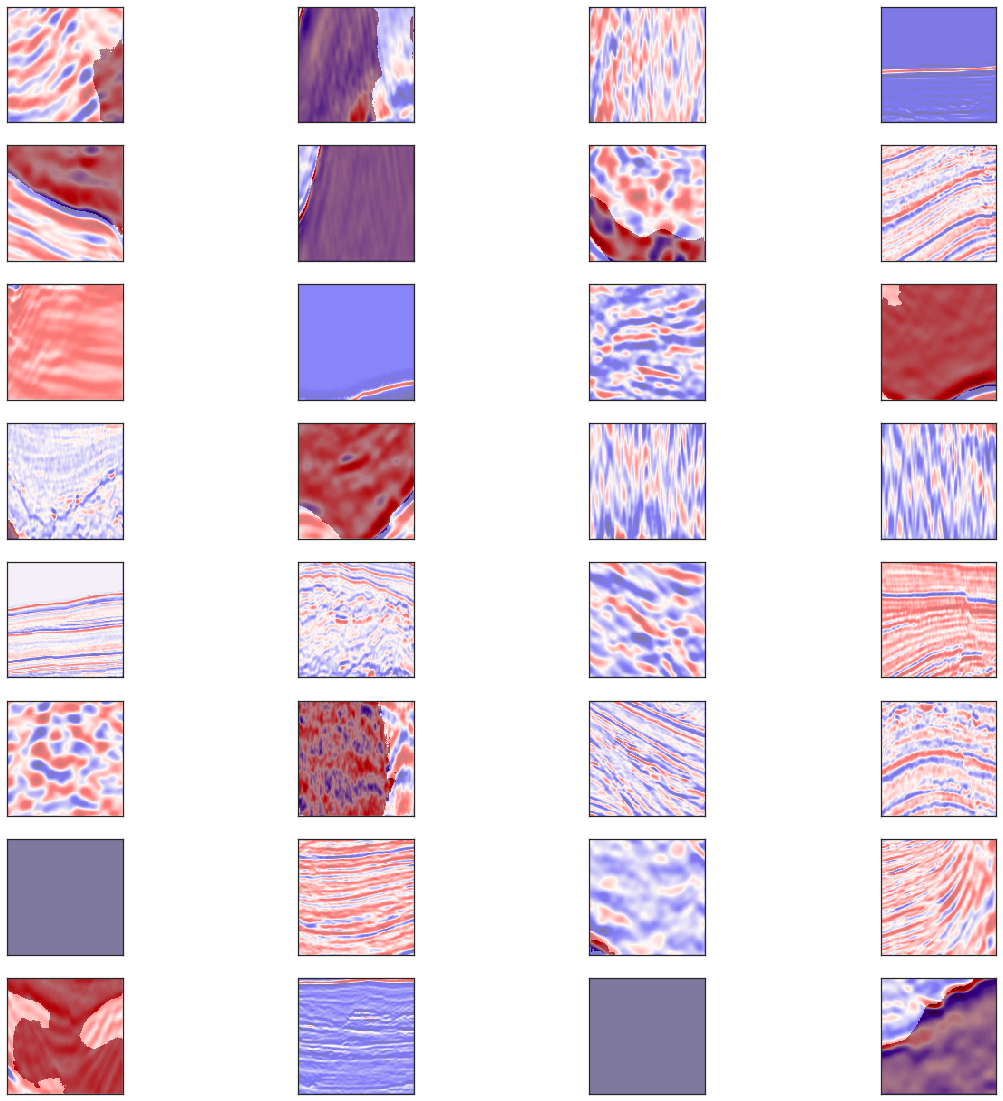

In [23]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = final_preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

# Apply CRF

In [24]:
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [25]:
"""
Applying CRF on the predicted mask 

"""
crf_output = []
for i in tqdm(range(X_test.shape[0])):
    crf_output.append(crf(np.squeeze(X_test[i]),np.squeeze(final_preds_test[i])))

100%|██████████| 18000/18000 [07:24<00:00, 40.48it/s]


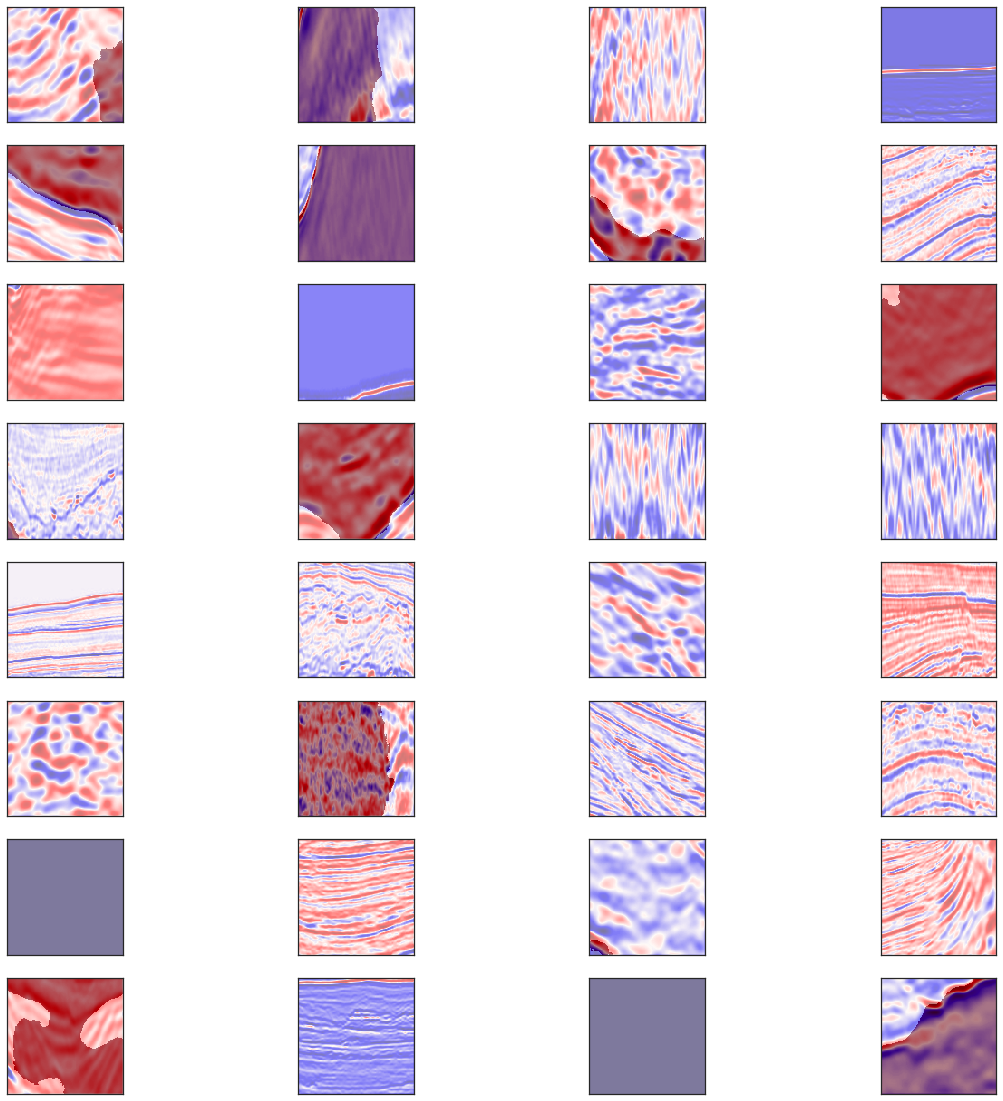

In [26]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = crf_output[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

In [27]:
threshold_best=threshold_best
pred_dict = {idx: RLenc(np.round(downsample(crf_output[i]))) for i, idx in enumerate(tqdm_notebook(test_df.img_id.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_pinet_crf.csv')